In [1]:
try:
  import pandas
except:
  !pip install pandas
  import pandas as pd
    
try:
  import numpy
except:
  !pip install numpy
  import numpy as np
    
try:
  import sklearn
except:
  !pip install scikit-learn
  import sklearn
    
try:
  import itertools
except:
  !pip install itertools

try:
  import torchmetrics
except:
  !pip install torchmetrics

try:
  import fnmatch
except:
  !pip install fnmatch

try:
  import seaborn
except:
  !pip install seaborn

In [2]:
from __future__ import print_function, division

import matplotlib
import pandas as pd
import numpy as np
from numpy import *
import matplotlib.pyplot as plt

import torchvision.models.segmentation
import torchvision.transforms as tf

import torch
import torch.nn as nn
import torch.nn.functional as F

# import torchvision
import torchvision.transforms as transforms
from torchvision.io import read_image

# from PIL import Image
from sklearn.model_selection import KFold, train_test_split
from scipy.stats import multivariate_normal

from torch.utils.data import TensorDataset, Dataset, DataLoader, random_split, SubsetRandomSampler, ConcatDataset, Subset

from torch.distributions import multivariate_normal
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions import normal

import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import math
import seaborn as sns

import sys
from torchmetrics.classification import AUROC
from sklearn import metrics
from itertools import cycle

from datetime import datetime
import fnmatch
from fnmatch import fnmatchcase
from PIL import Image

In [3]:
# Define the seeds

def set_seed(self, seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False
    random_state_Kfold = seed
    
seed = 0
set_seed(seed)

In [4]:
# 创建保存路径
simu_warmup_fold = "./Simu/"
copula_fold = "./Copula/"

os.makedirs(simu_warmup_fold, exist_ok=True) # 存在路径则不创建也不报错
os.makedirs(copula_fold, exist_ok=True) # 存在路径则不创建也不报错

In [5]:
# <<<<<< 表示调参修改的项目 <<<<<<

work_id = 100  # <<<<<< 这个是每个调参工作的唯一识别码，所有输出也带他，保证每次训练记录的唯一性，输出是 ”WorkID?_...“形式 <<<<<<

# seed_list = [1,2] # <<<<<< 先用一个试试看
seed_list = [0]

k = 5   # <<<<<< KFOLD <<<<<<
batch_size = 16 # <<<<<< BATCH SIZE <<<<<<
num_epochs = 60 # <<<<<< EPOCH <<<<<<

# resnet_output_size = 128  # <<<<<< ResNet输出的向量的维度，原始ResNet是1000 <<<<<<

validation_split = 0.25
shuffle_train_set = True
train_ratio = 0.8

learning_rate = 0.001
lr_decay_step_size = 20
lr_decay_prop = 0.5

cudnn.benchmark = True
plt.ion()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [6]:
X_length = 2614

In [7]:

PATH_ds = f'/root/autodl-tmp/warmup loader files/WorkID{work_id}_ds_XL_Data_seed{seed}_X_length{X_length}_batchsize{batch_size}_num_epoch120.pt'
ds_XL = torch.load(PATH_ds)


In [8]:
class rsn10_adapter (nn.Module):
    def __init__(self , num_classes=[2,2]):
        super(rsn10_adapter, self).__init__()
        
        nb_tasks = len(num_classes)
        
        
        self.conv1 = models.resnet18().conv1
        self.bn1=models.resnet18().bn1
        self.relu=models.resnet18().relu
        self.maxpool=models.resnet18().maxpool
        
        self.adapter1_0=nn.ModuleList([nn.Conv2d(64,64, kernel_size=1, padding=0) for i in range(nb_tasks)])
        self.adapter1_1=nn.ModuleList([nn.Conv2d(64,64, kernel_size=1, padding=0) for i in range(nb_tasks)])
        self.adapter1_2=nn.ModuleList([nn.Conv2d(64,64, kernel_size=1, padding=0) for i in range(nb_tasks)])
        self.adapter1_3=nn.ModuleList([nn.Conv2d(64,64, kernel_size=1, padding=0) for i in range(nb_tasks)])
        
        
        self.adapter2_0=nn.ModuleList([nn.Conv2d(64,128, kernel_size=1, padding=0, stride=2) for i in range(nb_tasks)])
        self.adapter2_1=nn.ModuleList([nn.Conv2d(128,128, kernel_size=1, padding=0) for i in range(nb_tasks)])
        self.adapter2_2=nn.ModuleList([nn.Conv2d(128,128, kernel_size=1, padding=0) for i in range(nb_tasks)])
        self.adapter2_3=nn.ModuleList([nn.Conv2d(128,128, kernel_size=1, padding=0) for i in range(nb_tasks)])
        
        # self.adapter3_0=nn.Conv2d(128,256, kernel_size=1, padding=0, stride=2)
        # self.adapter3_1=nn.Conv2d(256,256, kernel_size=1, padding=0)
        # self.adapter3_2=nn.Conv2d(256,256, kernel_size=1, padding=0)
        # self.adapter3_3=nn.Conv2d(256,256, kernel_size=1, padding=0)
        
        # self.adapter4_0=nn.Conv2d(256,512, kernel_size=1, padding=0, stride=2)
        # self.adapter4_1=nn.Conv2d(512,512, kernel_size=1, padding=0)
        # self.adapter4_2=nn.Conv2d(512,512, kernel_size=1, padding=0)
        # self.adapter4_3=nn.Conv2d(512,512, kernel_size=1, padding=0)

        self.layer1=models.resnet18().layer1
        self.layer2=models.resnet18().layer2
        # self.layer3=models.resnet18().layer3
        # self.layer4=models.resnet18().layer4
        self.avgpool=models.resnet18().avgpool
        #nn.init.xavier_uniform_(self.adapter1.weight, gain=0.01)
        #nn.init.xavier_uniform_(self.adapter2.weight, gain=0.01)
        #nn.init.xavier_uniform_(self.adapter3.weight, gain=0.01)
        #nn.init.xavier_uniform_(self.adapter4.weight, gain=0.01)

        # self.fc=models.resnet18().fc
        self.fc=nn.Linear(128, 2)
        
    def forward(self, x):
        y_vec = torch.tensor([]).to(device)
        
        for i in range(2):
            # print("i: ", i)
            task = i
            x_i = x[i]
            
            # print("x_i:", x_i)
            
            
            x_i = self.conv1(x_i)
            x_i = self.bn1(x_i)
            x_i = self.relu(x_i)
            x_i = self.maxpool(x_i)
            
            residual=x_i
            x_i = self.layer1[0].conv1(x_i) + self.adapter1_0[task](x_i)
            x_i = self.layer1[0].bn1(x_i)
            x_i = self.layer1[0].relu(x_i)
            x_i = self.layer1[0].conv2(x_i) + self.adapter1_1[task](x_i)
            x_i = self.layer1[0].bn2(x_i)
            x_i = x_i + residual
            x_i = self.layer1[0].relu(x_i)
            
            residual=x_i
            x_i = self.layer1[1].conv1(x_i) + self.adapter1_2[task](x_i)
            x_i = self.layer1[1].bn1(x_i)
            x_i = self.layer1[1].relu(x_i)
            x_i = self.layer1[1].conv2(x_i) + self.adapter1_3[task](x_i)
            x_i = self.layer1[1].bn2(x_i)
            x_i = x_i + residual
            x_i = self.layer1[1].relu(x_i)
            
            
            residual=x_i
            x_i = self.layer2[0].conv1(x_i) + self.adapter2_0[task](x_i)
            x_i = self.layer2[0].bn1(x_i)
            x_i = self.layer2[0].relu(x_i)
            x_i = self.layer2[0].conv2(x_i) + self.adapter2_1[task](x_i)
            x_i = self.layer2[0].bn2(x_i)
            residual = self.layer2[0].downsample(residual)
            x_i = x_i + residual
            x_i = self.layer2[0].relu(x_i)
            
            residual=x_i
            x_i = self.layer2[1].conv1(x_i) + self.adapter2_2[task](x_i)
            x_i = self.layer2[1].bn1(x_i)
            x_i = self.layer2[1].relu(x_i)
            x_i = self.layer2[1].conv2(x_i) + self.adapter2_3[task](x_i)
            x_i = self.layer2[1].bn2(x_i)
            x_i = x_i + residual
            x_i = self.layer2[1].relu(x_i)
            
            
            # residual=x_i
            # x_i = self.layer3[0].conv1(x_i) + self.adapter3_0(x_i)
            # x_i = self.layer3[0].bn1(x_i)
            # x_i = self.layer3[0].relu(x_i)
            # x_i = self.layer3[0].conv2(x_i) + self.adapter3_1(x_i)
            # x_i = self.layer3[0].bn2(x_i)
            # residual = self.layer3[0].downsample(residual)
            # x_i = x_i + residual
            # x_i = self.layer3[0].relu(x_i)
            
            # residual=x_i
            # x_i = self.layer3[1].conv1(x_i) + self.adapter3_2(x_i)
            # x_i = self.layer3[1].bn1(x_i)
            # x_i = self.layer3[1].relu(x_i)
            # x_i = self.layer3[1].conv2(x_i) + self.adapter3_3(x_i)
            # x_i = self.layer3[1].bn2(x_i)
            # x_i = x_i + residual
            # x_i = self.layer3[1].relu(x_i)
            
            
            # residual=x_i
            # x_i = self.layer4[0].conv1(x_i) + self.adapter4_0(x_i)
            # x_i = self.layer4[0].bn1(x_i)
            # x_i = self.layer4[0].relu(x_i)
            # x_i = self.layer4[0].conv2(x_i) + self.adapter4_1(x_i)
            # x_i = self.layer4[0].bn2(x_i)
            # residual = self.layer4[0].downsample(residual)
            # x_i = x_i + residual
            # x_i = self.layer4[0].relu(x_i)
            
            # residual=x_i
            # x_i = self.layer4[1].conv1(x_i) + self.adapter4_2(x_i)
            # x_i = self.layer4[1].bn1(x_i)
            # x_i = self.layer4[1].relu(x_i)
            # x_i = self.layer4[1].conv2(x_i) + self.adapter4_3(x_i)
            # x_i = self.layer4[1].bn2(x_i)
            # x_i = x_i + residual
            # x_i = self.layer4[1].relu(x_i)
            
            x_i = self.avgpool(x_i)
            x_i = x_i.view(x_i.size(0), -1)
            x_i = self.fc(x_i)
            
            # print("x_i final :", x_i)
            y_vec = torch.cat((y_vec,x_i), -1)
            # print(y_vec)
        return y_vec[:,0:2] , y_vec[:,2:4]  

In [9]:
# get_test_loss
def get_test_loss(net, criterion_regression, data_loader, sigma_hat):
    """Object: Monitor during training procedure, use traditional loss
       Input: net,
              criterion_classification,
              criterion_regression,
              data_loader: 注意输入数据的结构顺序不能变
       Output: loss_summary: a dictionary:
                    "avg_loss_left_classification"
                    "avg_loss_right_classification"
                    "avg_loss_left_regression"
                    "avg_loss_right_regression"
                    "avg_loss_left"
                    "avg_loss_right"
                    "avg_loss_classification"
                    "avg_loss_regression"
                    "avg_loss"
    """
    testing_loss_left_SE = [] # by bce
    testing_loss_right_SE = []
    testing_loss_left_AL = [] # by mse
    testing_loss_right_AL = []
    
    COPULA_testing_loss = []

    criterion_mse = nn.MSELoss()

    net.eval()

    with torch.no_grad():
        for data in data_loader:
            # Load data from loader (below 6 lines)
            X_left, X_right, age, gender, *labels= data
            inputs = X_left, X_right

            # get the data to GPU (if available)
            inputs = [_data.to(device) for _data in inputs]
            labels = [_label.to(device) for _label in labels]

            # Separate labels
            labels_left_SE = labels[3].squeeze().to(device).unsqueeze(0)
            labels_right_SE = labels[5].squeeze().to(device).unsqueeze(0)
            labels_left_AL = labels[2].squeeze().to(device).unsqueeze(0)
            labels_right_AL = labels[4].squeeze().to(device).unsqueeze(0)

            # Get and separate outputs
            outputs_left, outputs_right = net(inputs)
            outputs_left_SE = outputs_left[:, 0].unsqueeze(0)
            outputs_right_SE = outputs_right[:, 0].unsqueeze(0)
            outputs_left_AL = outputs_left[:, 1].unsqueeze(0)
            outputs_right_AL = outputs_right[:, 1].unsqueeze(0)

            y_hat = torch.cat((outputs_left_SE,outputs_left_AL,outputs_right_SE,outputs_right_AL),dim=0)
                
            y = torch.cat((labels_left_SE,labels_left_AL,labels_right_SE,labels_right_AL),dim=0)

            loss = criterion_copula(y_hat, y, sigma_hat)
            # add the loss of this batch to the list
            COPULA_testing_loss.append(loss.item())
            
            loss_left_SE = criterion_mse(outputs_left_SE, labels_left_SE)  # 不用reduce="none"，直接计算mean
            loss_right_SE = criterion_mse(outputs_right_SE, labels_right_SE)
            loss_left_AL = criterion_mse(outputs_left_AL, labels_left_AL)
            loss_right_AL = criterion_mse(outputs_right_AL, labels_right_AL)
            
            # Record loss elements
            testing_loss_left_SE.append(loss_left_SE)
            testing_loss_right_SE.append(loss_right_SE)
            testing_loss_left_AL.append(loss_left_AL)
            testing_loss_right_AL.append(loss_right_AL)
            
    # Cal the avg loss for each loss element
    avg_COPULA_loss = sum(COPULA_testing_loss) / len(COPULA_testing_loss)
    
    avg_loss_left_SE = torch.mean(torch.stack(testing_loss_left_SE)) # 这个没错，batch内部已经是平均值了，现在只要list的均值
    avg_loss_right_SE = torch.mean(torch.stack(testing_loss_right_SE)) # 同上
    avg_loss_left_AL = torch.mean(torch.stack(testing_loss_left_AL)) # 这个没错，batch内部已经是平均值了，现在只要list的均值
    avg_loss_right_AL =torch.mean(torch.stack(testing_loss_right_AL)) # 同上

    # Agg loss by row, col and total
    avg_loss_left = avg_loss_left_SE + avg_loss_left_AL
    avg_loss_right = avg_loss_right_SE + avg_loss_right_AL
    avg_loss_SE = avg_loss_left_SE + avg_loss_right_SE
    avg_loss_AL = avg_loss_left_AL + avg_loss_right_AL
    avg_loss = avg_loss_SE + avg_loss_AL # avg loss per item

    # Arrange the output
    loss_summary = {"avg_COPULA_loss": avg_COPULA_loss,
                    "avg_MSE_loss_left_SE": avg_loss_left_SE,
                    "avg_MSE_loss_right_SE": avg_loss_right_SE,
                    "avg_MSE_loss_left_AL": avg_loss_left_AL,
                    "avg_MSE_loss_right_AL": avg_loss_right_AL,
                    "avg_MSE_loss_left": avg_loss_left,
                    "avg_MSE_loss_right": avg_loss_right,
                    "avg_MSE_loss_SE": avg_loss_SE,
                    "avg_MSE_loss_AL": avg_loss_AL,
                    "avg_MSE_loss": avg_loss}

    # plt.plot(torch.tensor(testing_loss_left_classification, device = 'cpu'), label="testing_loss_left_classification")
    # plt.xlabel('Iteration')
    # plt.ylabel("testing_loss_left_classification")
    # plt.legend()
    # plt.show()

    return loss_summary

In [10]:
# test_stage
def test_stage(net,  criterion_regression , criterion_copula, test_loader, sigma_hat):
    # For AUC
    correct_classification_left = 0
    correct_classification_right = 0
    total_classification_times = 0

    # For MSE and BCE
    testing_loss_left_SE = []  # by bce
    testing_loss_right_SE = []
    testing_loss_left_AL = []  # by mse
    testing_loss_right_AL = []
    
    COPULA_testing_loss = []

    # For ROC
    y_left_test = []
    y_right_test = []
    y_left_score = []
    y_right_score = []

    net.eval()

    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in test_loader:
            # Load data from loader (below 4 lines)
            X_left, X_right, age, gender, *labels = data
            inputs = X_left, X_right

            # get the data to GPU (if available)
            inputs = [_data.to(device) for _data in inputs]
            labels = [_label.to(device) for _label in labels]

            # Separate labels
            labels_left_SE = labels[3].squeeze().to(device).unsqueeze(0)
            labels_right_SE = labels[5].squeeze().to(device).unsqueeze(0)
            labels_left_AL = labels[2].squeeze().to(device).unsqueeze(0)
            labels_right_AL = labels[4].squeeze().to(device).unsqueeze(0)

            # Get and separate outputs
            outputs_left, outputs_right = net(inputs)
            outputs_left_SE = outputs_left[:, 0].unsqueeze(0)
            outputs_right_SE = outputs_right[:, 0].unsqueeze(0)
            outputs_left_AL = outputs_left[:, 1].unsqueeze(0)
            outputs_right_AL = outputs_right[:, 1].unsqueeze(0)

            # Cal loss
            
            y_hat = torch.cat((outputs_left_SE,outputs_left_AL,outputs_right_SE,outputs_right_AL),dim=0)
                
            y = torch.cat((labels_left_SE,labels_left_AL,labels_right_SE,labels_right_AL),dim=0)

            loss_copula = criterion_copula(y_hat, y, sigma_hat)
            # add the loss of this batch to the list
            COPULA_testing_loss.append(loss_copula.item())
            
            
            # print("outputs_left_classification: ", outputs_left_classification)
            # print("labels_left_classification: ", labels_left_classification)
            loss_left_SE = criterion_regression(outputs_left_SE, labels_left_SE)  # 不用reduce="none"，直接计算mean
            loss_right_SE = criterion_regression(outputs_right_SE, labels_right_SE)
            loss_left_AL = criterion_regression(outputs_left_AL, labels_left_AL)
            loss_right_AL = criterion_regression(outputs_right_AL, labels_right_AL)

            # Record loss elements
            testing_loss_left_SE.append(loss_left_SE)
            testing_loss_right_SE.append(loss_right_SE)
            testing_loss_left_AL.append(loss_left_AL)
            testing_loss_right_AL.append(loss_right_AL)

            

    # Cal the avg loss for each loss element
    avg_COPULA_loss = sum(COPULA_testing_loss) / len(COPULA_testing_loss)
    
    avg_loss_left_SE = torch.mean(torch.stack(testing_loss_left_SE))  # 这个没错，batch内部已经是平均值了，现在只要list的均值
    avg_loss_right_SE = torch.mean(torch.stack(testing_loss_right_SE))  # 同上
    avg_loss_left_AL = torch.mean(torch.stack(testing_loss_left_AL))  # 这个没错，batch内部已经是平均值了，现在只要list的均值
    avg_loss_right_AL = torch.mean(torch.stack(testing_loss_right_AL))  # 同上

    # Agg loss by row, col and total
    avg_loss_left = avg_loss_left_SE + avg_loss_left_AL
    avg_loss_right = avg_loss_right_SE + avg_loss_right_AL
    avg_loss_SE = avg_loss_left_SE + avg_loss_right_SE
    avg_loss_AL = avg_loss_left_AL + avg_loss_right_AL
    avg_loss = avg_loss_SE + avg_loss_AL # avg loss per item

    # Arrange the output
    loss_summary = {"avg_COPULA_loss": avg_COPULA_loss,
                    "avg_MSE_loss_left_SE": avg_loss_left_SE,
                    "avg_MSE_loss_right_SE": avg_loss_right_SE,
                    "avg_MSE_loss_left_AL": avg_loss_left_AL,
                    "avg_MSE_loss_right_AL": avg_loss_right_AL,
                    "avg_MSE_loss_left": avg_loss_left,
                    "avg_MSE_loss_right": avg_loss_right,
                    "avg_MSE_loss_SE": avg_loss_SE,
                    "avg_MSE_loss_AL": avg_loss_AL,
                    "avg_MSE_loss": avg_loss}

    print('-' * 100)
    print("Performance of the BEST parameter setting on TEST set:")
    for key, val in loss_summary.items():
        if torch.is_tensor(val):
            val = val.item()
        print("\t {}: {}".format(key, val))

    return loss_summary




In [11]:
# 我们添加的函数，用来计算运行/剩余时
def format_time(seconds):
    """Formats the time in seconds into a string of hours, minutes, and seconds."""
    hours = int(seconds) // 3600
    minutes = (int(seconds) % 3600) // 60
    seconds = int(seconds) % 60
    return f'{hours:02d}h {minutes:02d}m {seconds:02d}s'

def print_training_progress(epoch, total_epochs, time_elapsed, kfold, present_fold):
    """Prints the training progaress including estimated total training time, time used, and estimated time left."""
    estimated_total_time = time_elapsed * ((total_epochs * kfold) / (total_epochs * fold + (epoch + 1)))
    time_used = format_time(time_elapsed)
    time_left = format_time(estimated_total_time - time_elapsed)
    total_training_time = format_time(estimated_total_time)

#     print(f'Epoch [{epoch+1}/{total_epochs}]')
    print(f'Time used: {time_used: >32}')
    print(f'Estimated time left: {time_left: >22}')
    print(f'Estimated total training time: {total_training_time: >12}')

# place to print time summary
# print_training_progress(epoch, num_epochs, time.time() - since, kfold, present_fold)

In [12]:
# Train model
def train_model(model, criterion_regression, criterion_copula, optimizer, scheduler, dl_train, dl_val, dl_test,
                num_epochs,sigma_hat):
    """Object:
       Input: model: 就是net，你构造的需要训练的网络
              criterion_classification:
              criterion_regression:
              optimizer: 实例化的一个优化器
              scheduler:
              dl_train:
              dl_val:
              num_epochs:
    """

    best_model_wts = copy.deepcopy(model.state_dict())  # 存储最佳参数
    least_loss = 10000000.0  # 存储最小损失
    best_epoch_num = 0  # 存储? # TODO
    val_loss = []  # return of get_test_loss per 20 batch
    n_train = int(len(dl_train))  # loader的长度，注意不是图片的张数，要翻倍

    # For plot
    train_loss_batchwise = []
    val_loss_batchwise = []
    test_loss_batchwise = []

    # Loop epoch
    for epoch in range(num_epochs):  # [0, num_epochs-1]
        # Report learning rate change if happened
        if epoch % exp_lr_scheduler.state_dict()['step_size'] == 0:
            print(">" * 30 + " Learning rate is to {} now.".format(
                exp_lr_scheduler.state_dict()['_last_lr'][0]) + "<" * 30)
        print('-' * 100)
        print(f'Epoch {epoch + 1}/{num_epochs}')

        model.train()

        running_loss = 0.0
        running_loss_temp = 0.0

        # Loop train data in one epoch
        for i, data in enumerate(dl_train, 0):  # i 从0开始
            # Load data from loader (below 4 lines)
            X_left, X_right, age, gender, *labels = data
            inputs = X_left, X_right, age, gender

            # get the data to GPU (if available)
            inputs = [_data.to(device) for _data in inputs]
            labels = [_label.to(device) for _label in labels]

            # Separate labels
            labels_left_SE = labels[3].squeeze().to(device).unsqueeze(0)
            labels_right_SE = labels[5].squeeze().to(device).unsqueeze(0)
            labels_left_AL = labels[2].squeeze().to(device).unsqueeze(0)
            labels_right_AL = labels[4].squeeze().to(device).unsqueeze(0)

            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
                # 前向传播
                outputs_left, outputs_right = model(inputs)
                outputs_left_SE = outputs_left[:, 0].unsqueeze(0)
                outputs_right_SE = outputs_right[:, 0].unsqueeze(0)
                outputs_left_AL = outputs_left[:, 1].unsqueeze(0)
                outputs_right_AL = outputs_right[:, 1].unsqueeze(0)
                
                y_hat = torch.cat((outputs_left_SE,outputs_left_AL,outputs_right_SE,outputs_right_AL),dim=0)
                
                y = torch.cat((labels_left_SE,labels_left_AL,labels_right_SE,labels_right_AL),dim=0)

                loss = criterion_copula(y_hat, y, sigma_hat)

                # 反向传播
                loss.backward()
                # 更新
                optimizer.step()

            running_loss += loss.item()  # 记录每个epoch的平均loss
            running_loss_temp += loss.item()  # 记录每20个batch的累计loss

            if i % 20 == 19:
                # record train/val/test loss per 20 batch for plot
                # train_loss_summary = get_test_loss(model, criterion_classification, criterion_regression, dl_train)
                val_loss_summary = get_test_loss(model,  criterion_copula, dl_val, sigma_hat)
                # test_loss_summary = get_test_loss(model, criterion_classification, criterion_regression, dl_test)

                # 下方使用item，把cuda里的tensor的数值部分提取到cpu里，这种方法比什么tensor.to("cpu")来得直接
                # train_loss_batchwise.append(train_loss_summary["avg_loss"].item())
                # # avg_val_loss_cla_reg_sum = get_test_loss(model, criterion_classification, criterion_regression, dl_val)
                # val_loss_batchwise.append(val_loss_summary["avg_loss"].item())
                # test_loss_batchwise.append(test_loss_summary["avg_loss"].item())
                avg_val_loss_l_r_cla_reg_sum = [val_loss_summary["avg_COPULA_loss"],
                                                val_loss_summary["avg_MSE_loss_left"],
                                                val_loss_summary["avg_MSE_loss_right"],
                                                val_loss_summary["avg_MSE_loss_SE"],
                                                val_loss_summary["avg_MSE_loss_AL"],
                                                val_loss_summary["avg_MSE_loss"]]
                    
                avg_loss_str = ' '.join(f'{value:.3f}' for value in avg_val_loss_l_r_cla_reg_sum)
                # Avg train loss past 20 batch: the mean of train losses of model during past 20 batch
                # Val LRClaRegTot loss this batch: the Left, Right, Classification, Regression, and Total loss of model with parameter attained in this batch on val set
                print(
                    f'[Num of batch: {i + 1:2d}] Avg train loss past 20 batch: {running_loss_temp / 20 :.3f} | Val LRClaRegTot loss this batch: {avg_loss_str} ')  # Epoch: {epoch + 1},
                # print(f'\t Train loss this batch: {train_loss_batchwise :.3f}') # <<<<<< 和 Val tot loss this batch 相对于的
                running_loss_temp = 0.0

        # 每个epoch结束时计算三个loss，输出，并在之后用来画loss plot
        # 下方使用item，把cuda里的tensor的数值部分提取到cpu里，这种方法比什么tensor.to("cpu")来得直接
        train_loss_summary = get_test_loss(model,  criterion_copula, dl_train, sigma_hat)
        val_loss_summary = get_test_loss(model,  criterion_copula, dl_val, sigma_hat)
        test_loss_summary = get_test_loss(model,  criterion_copula, dl_test, sigma_hat)
                
        train_loss_batchwise.append(train_loss_summary["avg_COPULA_loss"].item())
        val_loss_batchwise.append(val_loss_summary["avg_COPULA_loss"].item())
        test_loss_batchwise.append(test_loss_summary["avg_COPULA_loss"].item())
        
        print("-"*20)
        print("Train copula loss this batch: ", train_loss_summary["avg_COPULA_loss"].item())
        print("Val copula loss this batch:   ", val_loss_summary["avg_COPULA_loss"].item())
        print("Test copula loss this batch:  ", test_loss_summary["avg_COPULA_loss"].item())
        
        print("Train MSE loss this batch: ", train_loss_summary["avg_MSE_loss"].item())
        print("Val MSE loss this batch:   ", val_loss_summary["avg_MSE_loss"].item())
        print("Test MSE loss this batch:  ", test_loss_summary["avg_MSE_loss"].item())
        
        print("-"*20)
                
        # ##################################### TEST BEGIN ######################################
        # print("oucopula.fc_cla.weight.data: ", oucopula.fc_cla.weight.data)
        # print("oucopula.fc_reg.weight.data: ", oucopula.fc_reg.weight.data)
        # print("oucopula.resnetl.model_resnet.conv1.weight.data: ", oucopula.resnetl.model_resnet.conv1.weight.data)
        # ###################################### TEST END #######################################

        scheduler.step()  # 放在epoch循环里

        # epoch_loss = running_loss / n_train  # Set to 0 per epoch # 这里计算无误
        # # Avg train loss in this epoch: the mean of train losses of model during this epoch
        # print(f'Avg train loss in this epoch: {epoch_loss:.4f}')
        # print("n_train: ", n_train)

        # Cal and record best model over val set over epoches
        # 这边只能使用val_dataset，不能使用test set，test是用来检验此处挑选出的模型的
        avg_val_loss_this_epoch = get_test_loss(model,  criterion_copula, dl_val, sigma_hat)["avg_COPULA_loss"]

        if avg_val_loss_this_epoch < least_loss: # 使用val loss选择最优模型
            least_loss = avg_val_loss_this_epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            best_epoch_num = epoch

        # place to print time summary
        print_training_progress(epoch, num_epochs, time.time() - since, k, fold)
        print()
        
        # ====== This is the end of code within a epoch ======#

    # Load the BEST model when the training process for all epoches is ended
    model.load_state_dict(best_model_wts)

    avg_train_loss_best_model = get_test_loss(model,  criterion_copula, dl_train, sigma_hat)["avg_COPULA_loss"]
    avg_val_loss_best_model = get_test_loss(model,  criterion_copula, dl_val, sigma_hat)["avg_COPULA_loss"]
    avg_test_loss_best_model = get_test_loss(model,  criterion_copula, dl_test, sigma_hat)["avg_COPULA_loss"]

    # Evaluate the BEST model
    print('-' * 100)
    print("Evaluate the best parameter setting acquired in this fold: ")
    print("\t Best setting acquired in Epoch: {}/{}".format(best_epoch_num + 1, num_epochs))
    print("\t Avg loss on train set: {:.3f}".format(avg_train_loss_best_model))
    print("\t Avg loss on validation set: {:.3f}".format(avg_val_loss_best_model))
    print("\t Avg loss on test set: {:.3f}".format(avg_test_loss_best_model))

    return model, train_loss_batchwise, val_loss_batchwise, test_loss_batchwise

In [13]:
def plot_loss(batch_num_per_epoch, train_loss, val_loss, test_loss):
    plt.figure(figsize=(50, 30))
    x = range(1, len(train_loss) + 1)
    xticks = range(1, len(train_loss) + 1, 2)
    
    plt.plot(x, train_loss, label='Train Loss')
    plt.plot(x, val_loss, label='Validation Loss')
    plt.plot(x, test_loss, label='Test Loss')
    
    plt.xticks(xticks, fontsize=12)
    plt.xlabel('Per 20 Epochs')
    plt.ylabel('Loss')
    plt.title('Itemwise Loss Per 20 Batch')
    plt.legend()
    plt.savefig(f'./Simu/WorkID{work_id}_Simu_LossPlot_seed{seed}_fold{fold}_X_length{X_length}_batchsize{batch_size}_num_epoch{num_epochs}.png')
    plt.show()

In [14]:
class parametricLoss(nn.Module):
    def __init__(self):
        super(parametricLoss, self).__init__()
 
    def forward(self, y_hat, y, sigma_hat):
        ei = y - y_hat
        # print(ei)
        dist = multivariate_normal.MultivariateNormal(loc=torch.zeros(4).cuda(), 
                                                      covariance_matrix=sigma_hat)
        pdf = -dist.log_prob(ei.T)
        loss = torch.mean(pdf)
        
        return loss 
    
def calculate_sigma_hat(dl_train,net):
    net.eval()
    ts_resid = torch.empty(0).to(device)
    # calculate residual for every training sample
    with torch.no_grad():
        for i, data in enumerate(dl_train, 0):
            X_left, X_right, age, gender, *labels = data
            inputs = X_left, X_right, age, gender

            # get the data to GPU (if available)
            inputs = [_data.to(device) for _data in inputs]
            labels = [_label.to(device) for _label in labels]

            # Separate labels
            labels_left_SE = labels[3].squeeze().to(device)
            labels_right_SE = labels[5].squeeze().to(device)
            labels_left_AL = labels[2].squeeze().to(device)
            labels_right_AL = labels[4].squeeze().to(device)
            
            outputs_left, outputs_right = net(inputs)
            outputs_left_SE = outputs_left[:, 0]
            outputs_right_SE = outputs_right[:, 0]
            outputs_left_AL = outputs_left[:, 1]
            outputs_right_AL = outputs_right[:, 1]
            
            resid_left_SE = labels_left_SE - outputs_left_SE
            resid_right_SE = labels_right_SE - outputs_right_SE
            resid_left_AL = labels_left_AL - outputs_left_AL
            resid_right_AL = labels_right_AL - outputs_right_AL
            
            resid_left_SE = resid_left_SE.unsqueeze(0)
            resid_right_SE = resid_right_SE.unsqueeze(0)
            resid_left_AL = resid_left_AL.unsqueeze(0)
            resid_right_AL = resid_right_AL.unsqueeze(0)
            
            resid_abcd = torch.cat((resid_left_SE,resid_left_AL,resid_right_SE,resid_right_AL),dim=0)
            ts_resid = torch.cat((ts_resid,resid_abcd),dim=-1)

    ei = ts_resid
    print("ei: ", ei)

    plot_scatter_corrcoef_left(ei)
    plot_scatter_corrcoef_right(ei)

    sigma_hat = torch.cov(ei)
    print("sigma_hat: ", sigma_hat)
    return sigma_hat

# def plot_scatter_corrcoef(labels):
#     import matplotlib.pyplot as plt
#     import numpy as np
#     import scipy.stats as stats

#     plt.scatter(labels.cpu()[:,0], labels.cpu()[:,1])
#     plt.title('Scatter plot with correlation coefficient')
#     plt.xlabel('X')
#     plt.ylabel('Y')
#     r, p = stats.pearsonr(labels.cpu()[:,0], labels.cpu()[:,1])
#     plt.annotate('r = {:.4f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')
#     plt.show()
#     return

def plot_scatter_corrcoef_left(labels):
    import matplotlib.pyplot as plt
    import numpy as np
    import scipy.stats as stats

    plt.scatter(labels.cpu()[0], labels.cpu()[1])
    plt.title('Scatter plot with correlation coefficient LEFT eyes')
    plt.xlabel('X')
    plt.ylabel('Y')
    r, p = stats.pearsonr(labels.cpu()[:,0], labels.cpu()[:,1])
    plt.annotate('r = {:.4f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')
    plt.show()
    return

def plot_scatter_corrcoef_right(labels):
    import matplotlib.pyplot as plt
    import numpy as np
    import scipy.stats as stats

    plt.scatter(labels.cpu()[2], labels.cpu()[3])
    plt.title('Scatter plot with correlation coefficient RIGHT eyes')
    plt.xlabel('X')
    plt.ylabel('Y')
    r, p = stats.pearsonr(labels.cpu()[:,0], labels.cpu()[:,1])
    plt.annotate('r = {:.4f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')
    plt.show()
    return

def plot_scatter_corrcoef_loaders(dataloader, net):
    import matplotlib.pyplot as plt
    import numpy as np
    import scipy.stats as stats
    
    net.eval()
    ts_resid = torch.empty(0).to(device)
    # calculate residual for every training sample
    with torch.no_grad():
        for i, data in enumerate(dataloader, 0):
            X_left, X_right, age, gender, *labels = data
            inputs = X_left, X_right, age, gender

            # get the data to GPU (if available)
            inputs = [_data.to(device) for _data in inputs]
            labels = [_label.to(device) for _label in labels]

            # Separate labels
            labels_left_SE = labels[3].squeeze().to(device)
            labels_right_SE = labels[5].squeeze().to(device)
            labels_left_AL = labels[2].squeeze().to(device)
            labels_right_AL = labels[4].squeeze().to(device)
            
            outputs_left, outputs_right = model(inputs)
            outputs_left_SE = outputs_left[:, 0]
            outputs_right_SE = outputs_right[:, 0]
            outputs_left_AL = outputs_left[:, 1]
            outputs_right_AL = outputs_right[:, 1]
            
            resid_left_SE = labels_left_SE - outputs_left_SE
            resid_right_SE = labels_right_SE - outputs_right_SE
            resid_left_AL = labels_left_AL - outputs_left_AL
            resid_right_AL = labels_right_AL - outputs_right_AL

            resid_abcd = torch.cat((resid_left_SE,resid_left_AL,resid_right_SE,resid_right_AL),dim=-1)
            resid_abcd = resid_abcd.unsqueeze(0)
            ts_resid = torch.cat((ts_resid,resid_abcd),dim=0)

    plot_scatter_corrcoef_left(ei)
    plot_scatter_corrcoef_right(ei)
    return

    ooo  u   u  ccc   ooo  pppp  u   u l      a
  o   o u   u c     o   o p   p u   u l      a a
 o   o u   u c     o   o pppp  u   u l     aaaaa
 ooo   uuu   ccc   ooo  p      uuu  llll a     a
WorkID: 100
This experiment started at: 2023-12-11 20:44:32
Important parameters: 
	Python version: 3.8.10 (default, Jun  4 2021, 15:09:15) 
[GCC 7.5.0]
	Pytorch version:  2.0.0+cu118
	Batch num per epoch:  98
	learning_rate:  0.001
	Learning rate decay every 20 epoches.
Other parameters: 
	Random state KFold:  0
	Seed:  0
	KFold:  5
	Batch size:  16
	Number of epochs:  60
	Sample size:  2614
	shuffle_train_set:  True
	train_ratio (prop of train+val):  0.8
	validation_split:  0.25

Fold 1
ei:  tensor([[ 8.0173e-01, -8.3914e-01,  1.3306e+00,  ..., -5.4037e+00,
         -1.1662e+00,  7.3307e+00],
        [-1.1949e+00, -1.7497e+00, -3.4355e-01,  ..., -3.2432e+00,
         -1.5987e+00,  4.3109e+00],
        [ 2.9313e+00,  4.3970e+00,  1.7095e+00,  ..., -8.6803e-03,
         -4.9836e-01,  9.3610e+00

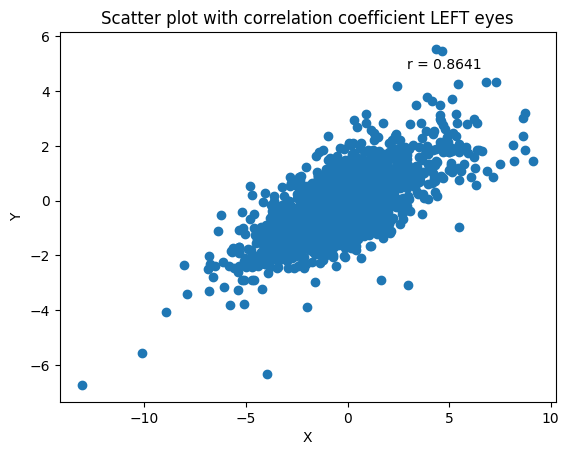

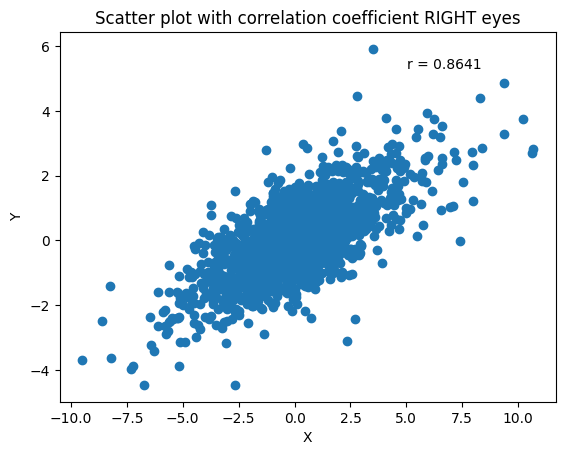

sigma_hat:  tensor([[6.0531, 2.1168, 4.2917, 1.4009],
        [2.1168, 1.5143, 1.3750, 1.0623],
        [4.2917, 1.3750, 6.0071, 2.0929],
        [1.4009, 1.0623, 2.0929, 1.4784]], device='cuda:0')
CopulaPara: 
gamma_hat:  tensor([[6.0531, 2.1168, 4.2917, 1.4009],
        [2.1168, 1.5143, 1.3750, 1.0623],
        [4.2917, 1.3750, 6.0071, 2.0929],
        [1.4009, 1.0623, 2.0929, 1.4784]], device='cuda:0')

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Learning rate is to 0.001 now.<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
----------------------------------------------------------------------------------------------------
Epoch 1/60
[Num of batch: 20] Avg train loss past 20 batch: 6.230 | Val LRClaRegTot loss this batch: 6.511 11.068 10.363 17.326 4.105 21.431 
[Num of batch: 40] Avg train loss past 20 batch: 6.199 | Val LRClaRegTot loss this batch: 6.429 10.610 9.551 16.200 3.962 20.162 
[Num of batch: 60] Avg train loss past 20 batch: 6.601 | Val LRClaRegTot loss this batch: 6.386 10.754 9.612 16.481 3.884 20.

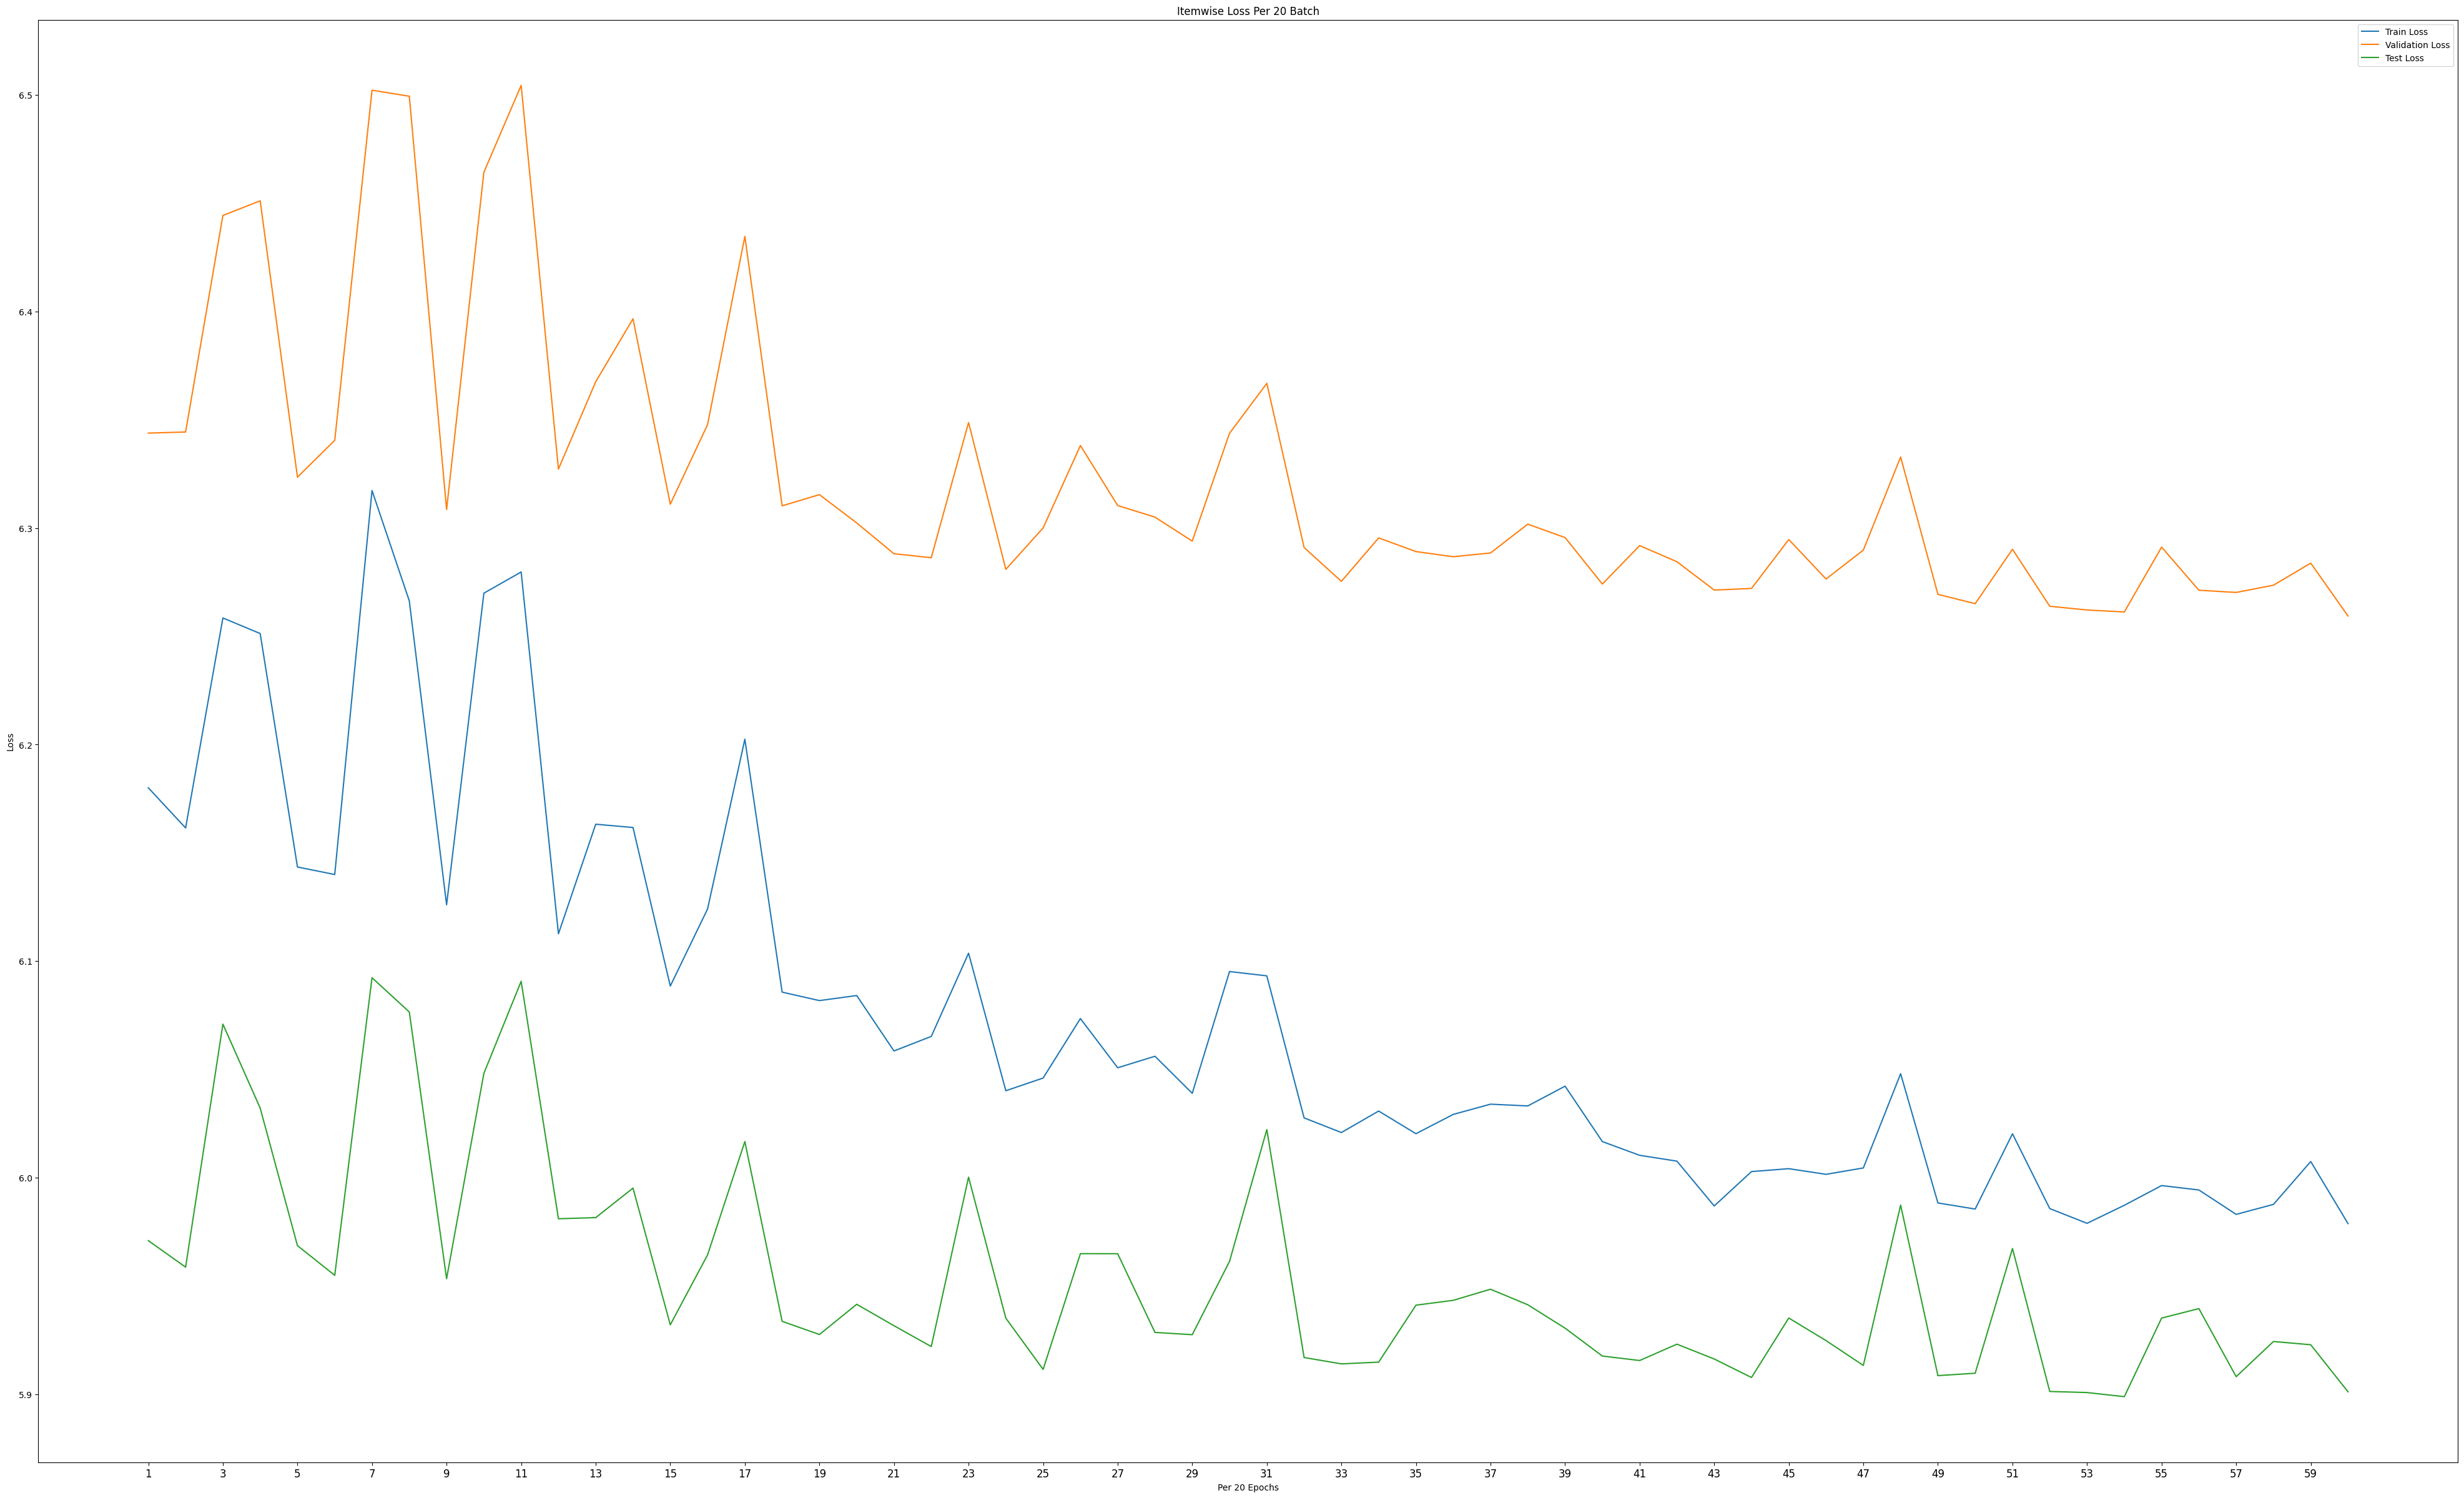

----------------------------------------------------------------------------------------------------
Performance of the BEST parameter setting on TEST set:
	 avg_COPULA_loss: 5.901070460677147
	 avg_MSE_loss_left_SE: 6.039078235626221
	 avg_MSE_loss_right_SE: 6.1866607666015625
	 avg_MSE_loss_left_AL: 1.3642034530639648
	 avg_MSE_loss_right_AL: 1.3874096870422363
	 avg_MSE_loss_left: 7.4032816886901855
	 avg_MSE_loss_right: 7.574070453643799
	 avg_MSE_loss_SE: 12.225738525390625
	 avg_MSE_loss_AL: 2.751613140106201
	 avg_MSE_loss: 14.977352142333984
Fold 2
ei:  tensor([[ 2.6670, -0.4860, -5.4562,  ...,  0.6423, -2.3105, -2.9156],
        [ 1.3697,  0.1459, -1.7081,  ...,  0.2125, -2.4702, -0.6140],
        [ 2.6838,  0.6932, -3.5694,  ...,  3.4965,  0.7050, -1.9677],
        [ 0.9278,  0.4219, -0.7891,  ...,  0.5418, -0.3505, -0.4114]],
       device='cuda:0')


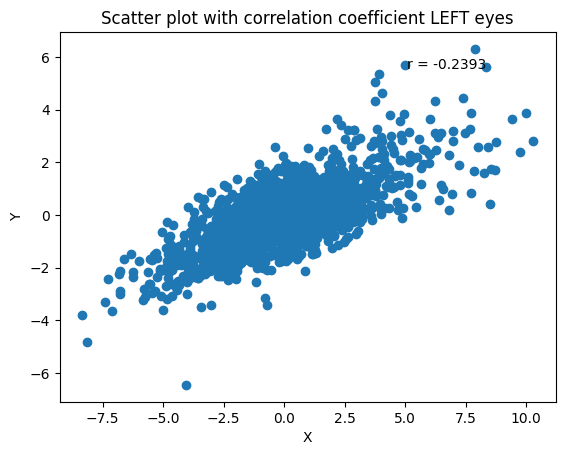

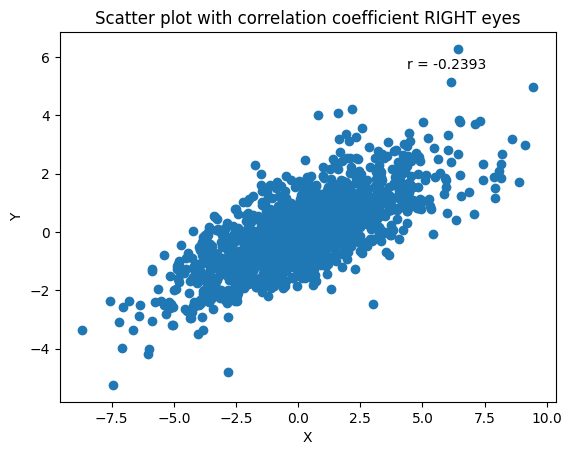

sigma_hat:  tensor([[6.6974, 2.4279, 4.7031, 1.6371],
        [2.4279, 1.6678, 1.5902, 1.2041],
        [4.7031, 1.5902, 6.4068, 2.3040],
        [1.6371, 1.2041, 2.3040, 1.5822]], device='cuda:0')
CopulaPara: 
gamma_hat:  tensor([[6.6974, 2.4279, 4.7031, 1.6371],
        [2.4279, 1.6678, 1.5902, 1.2041],
        [4.7031, 1.5902, 6.4068, 2.3040],
        [1.6371, 1.2041, 2.3040, 1.5822]], device='cuda:0')

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Learning rate is to 0.001 now.<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
----------------------------------------------------------------------------------------------------
Epoch 1/60
[Num of batch: 20] Avg train loss past 20 batch: 6.521 | Val LRClaRegTot loss this batch: 6.337 8.854 9.437 14.711 3.580 18.291 
[Num of batch: 40] Avg train loss past 20 batch: 6.323 | Val LRClaRegTot loss this batch: 6.284 9.020 9.502 14.723 3.799 18.522 
[Num of batch: 60] Avg train loss past 20 batch: 6.223 | Val LRClaRegTot loss this batch: 6.260 9.054 9.711 15.186 3.579 18.765 

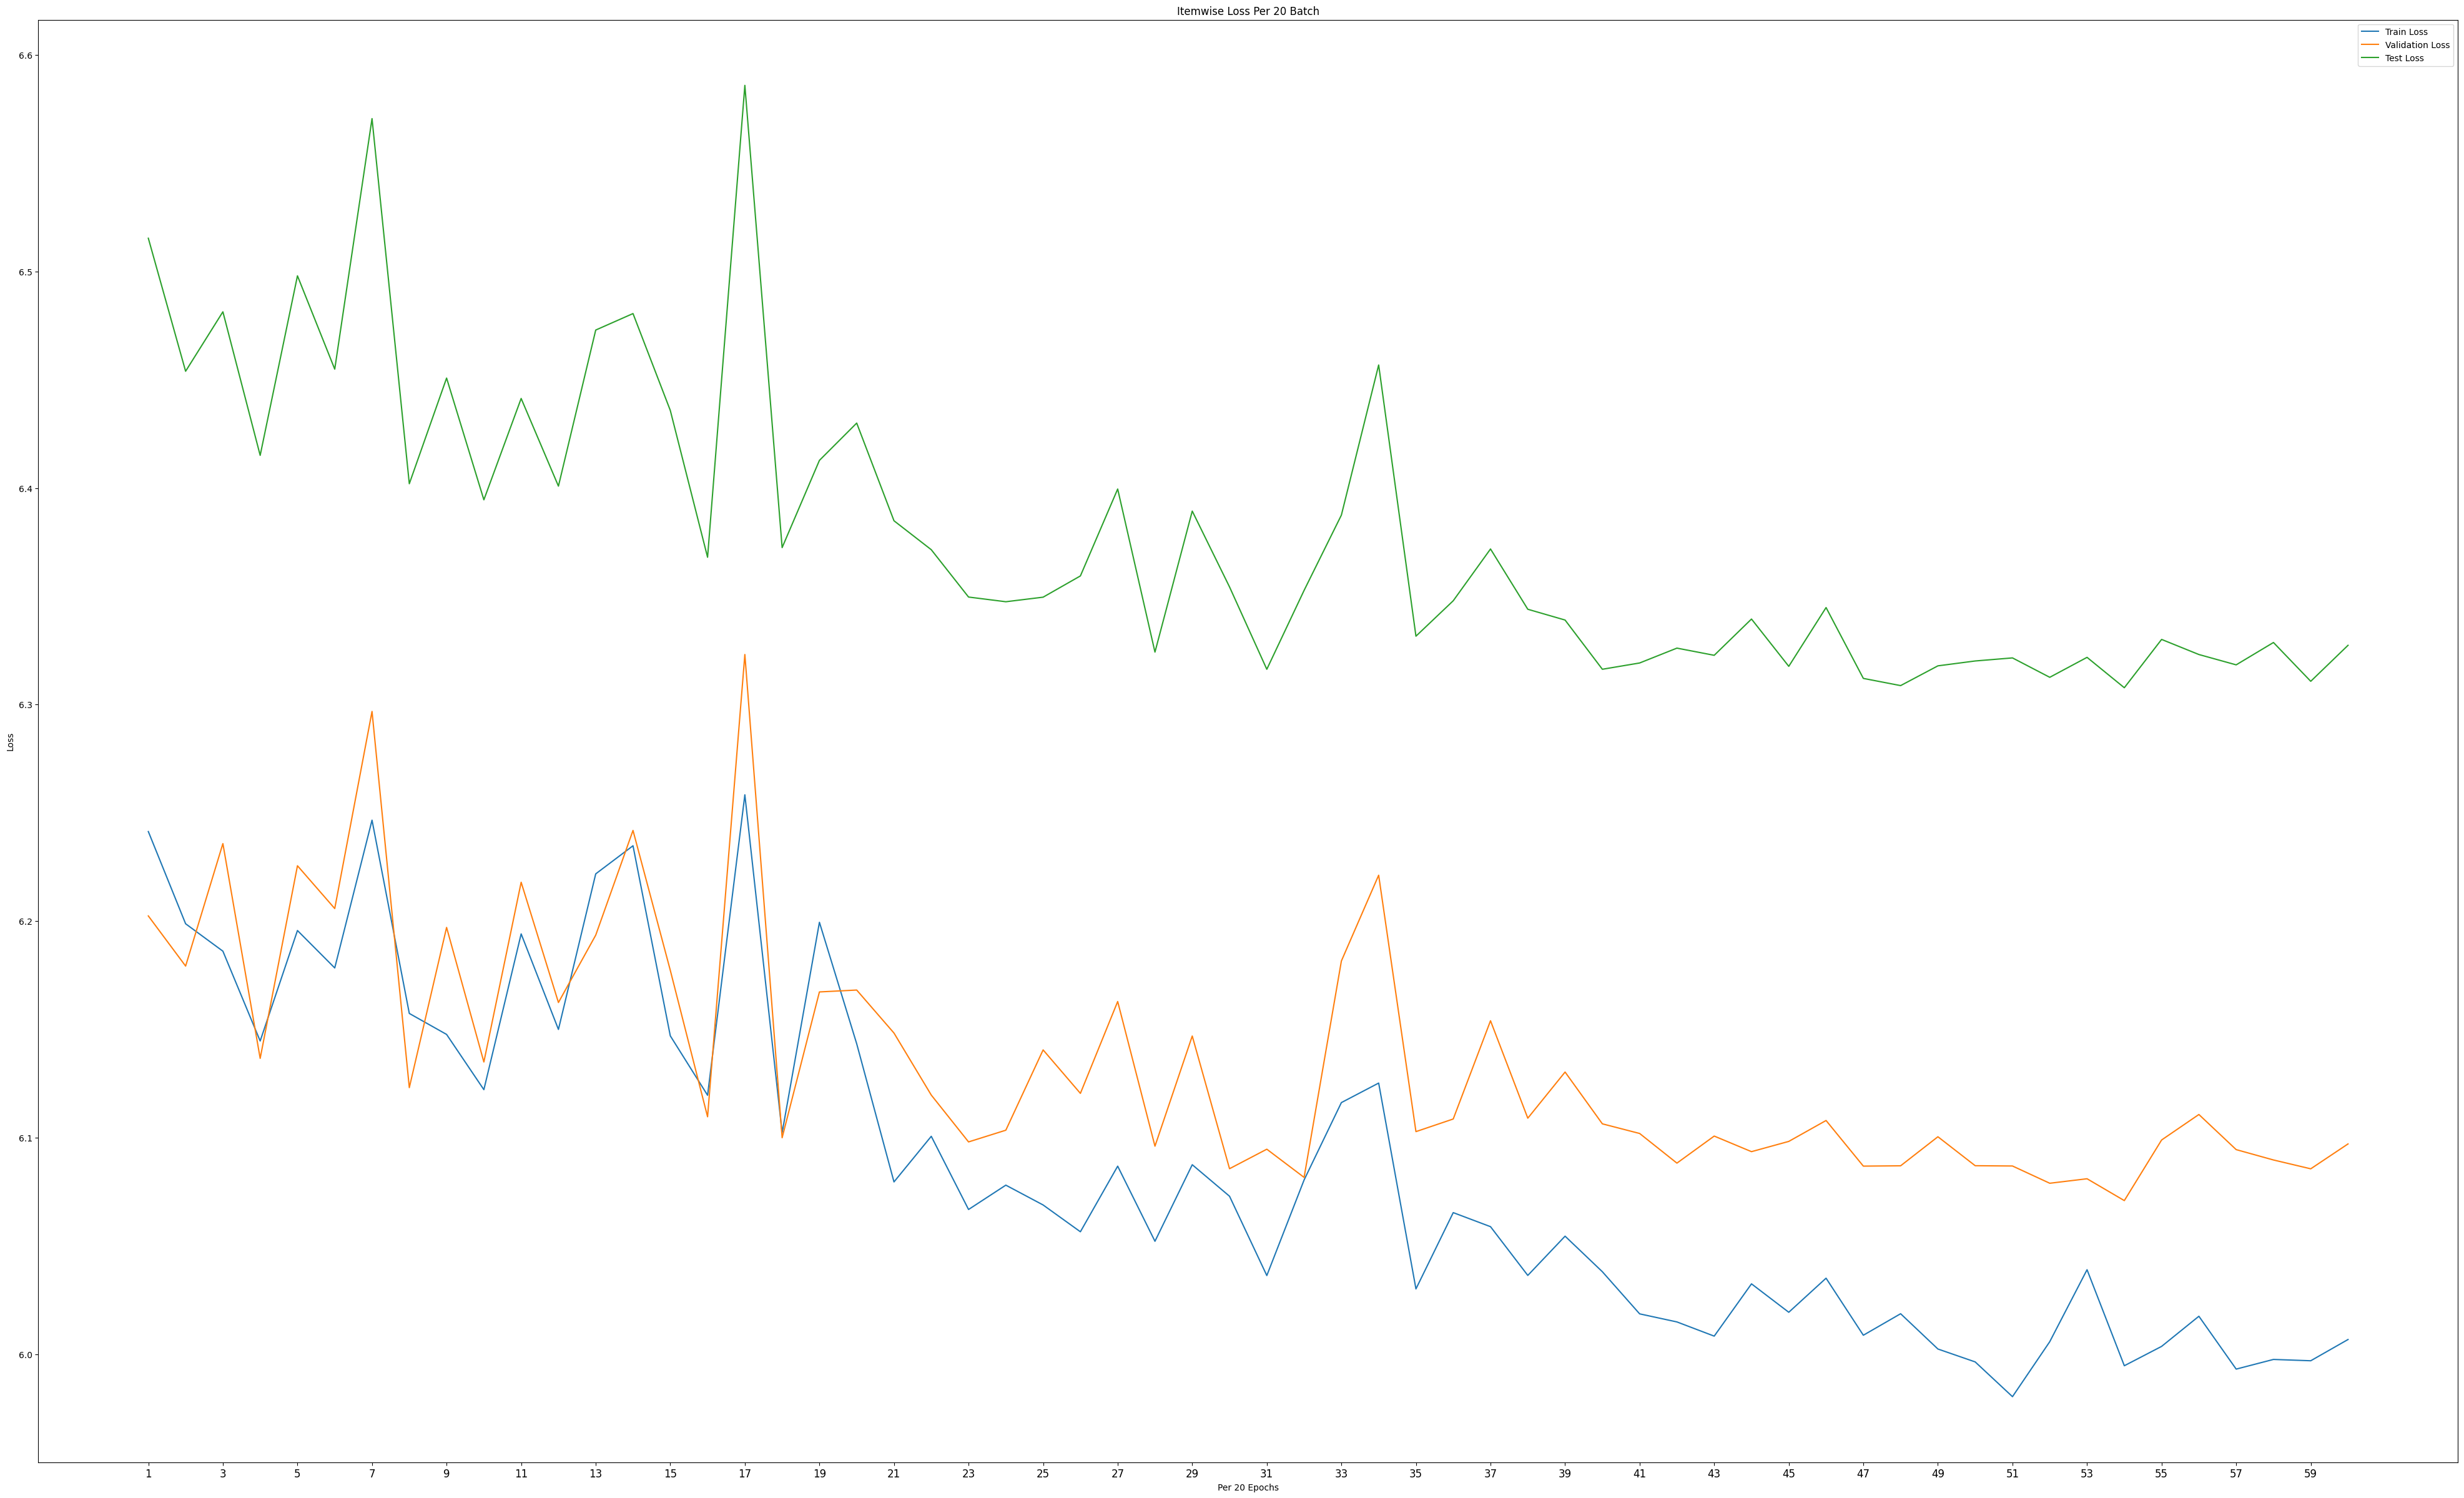

----------------------------------------------------------------------------------------------------
Performance of the BEST parameter setting on TEST set:
	 avg_COPULA_loss: 6.307786405086517
	 avg_MSE_loss_left_SE: 7.815070152282715
	 avg_MSE_loss_right_SE: 7.425348281860352
	 avg_MSE_loss_left_AL: 1.6494419574737549
	 avg_MSE_loss_right_AL: 1.7216169834136963
	 avg_MSE_loss_left: 9.46451187133789
	 avg_MSE_loss_right: 9.146965026855469
	 avg_MSE_loss_SE: 15.240418434143066
	 avg_MSE_loss_AL: 3.371058940887451
	 avg_MSE_loss: 18.61147689819336
Fold 3
ei:  tensor([[-0.3378,  2.0096, -0.6889,  ...,  0.7584,  2.8001, -2.7805],
        [-0.5535, -0.1502,  1.7747,  ..., -1.2086,  1.5383, -0.7518],
        [ 1.4379,  0.2838, -0.7063,  ...,  2.3693,  3.0530, -2.7424],
        [-0.0142, -1.0306,  1.6390,  ..., -0.0881,  0.6794, -0.6429]],
       device='cuda:0')


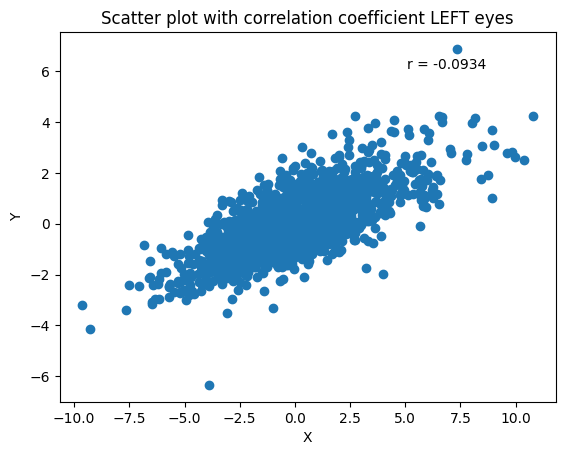

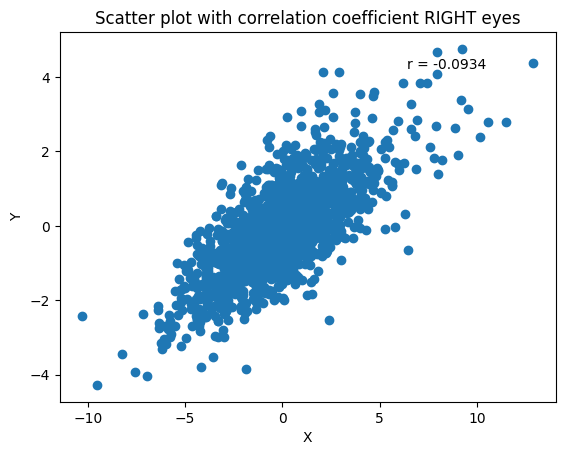

sigma_hat:  tensor([[6.9730, 2.3951, 5.0149, 1.6816],
        [2.3951, 1.5674, 1.6037, 1.1436],
        [5.0149, 1.6037, 6.7017, 2.3176],
        [1.6816, 1.1436, 2.3176, 1.5017]], device='cuda:0')
CopulaPara: 
gamma_hat:  tensor([[6.9730, 2.3951, 5.0149, 1.6816],
        [2.3951, 1.5674, 1.6037, 1.1436],
        [5.0149, 1.6037, 6.7017, 2.3176],
        [1.6816, 1.1436, 2.3176, 1.5017]], device='cuda:0')

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Learning rate is to 0.001 now.<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
----------------------------------------------------------------------------------------------------
Epoch 1/60
[Num of batch: 20] Avg train loss past 20 batch: 6.358 | Val LRClaRegTot loss this batch: 6.773 9.997 9.768 15.447 4.318 19.764 
[Num of batch: 40] Avg train loss past 20 batch: 6.367 | Val LRClaRegTot loss this batch: 6.802 10.644 10.237 16.256 4.624 20.881 
[Num of batch: 60] Avg train loss past 20 batch: 6.121 | Val LRClaRegTot loss this batch: 6.652 10.382 10.346 16.094 4.633 20.

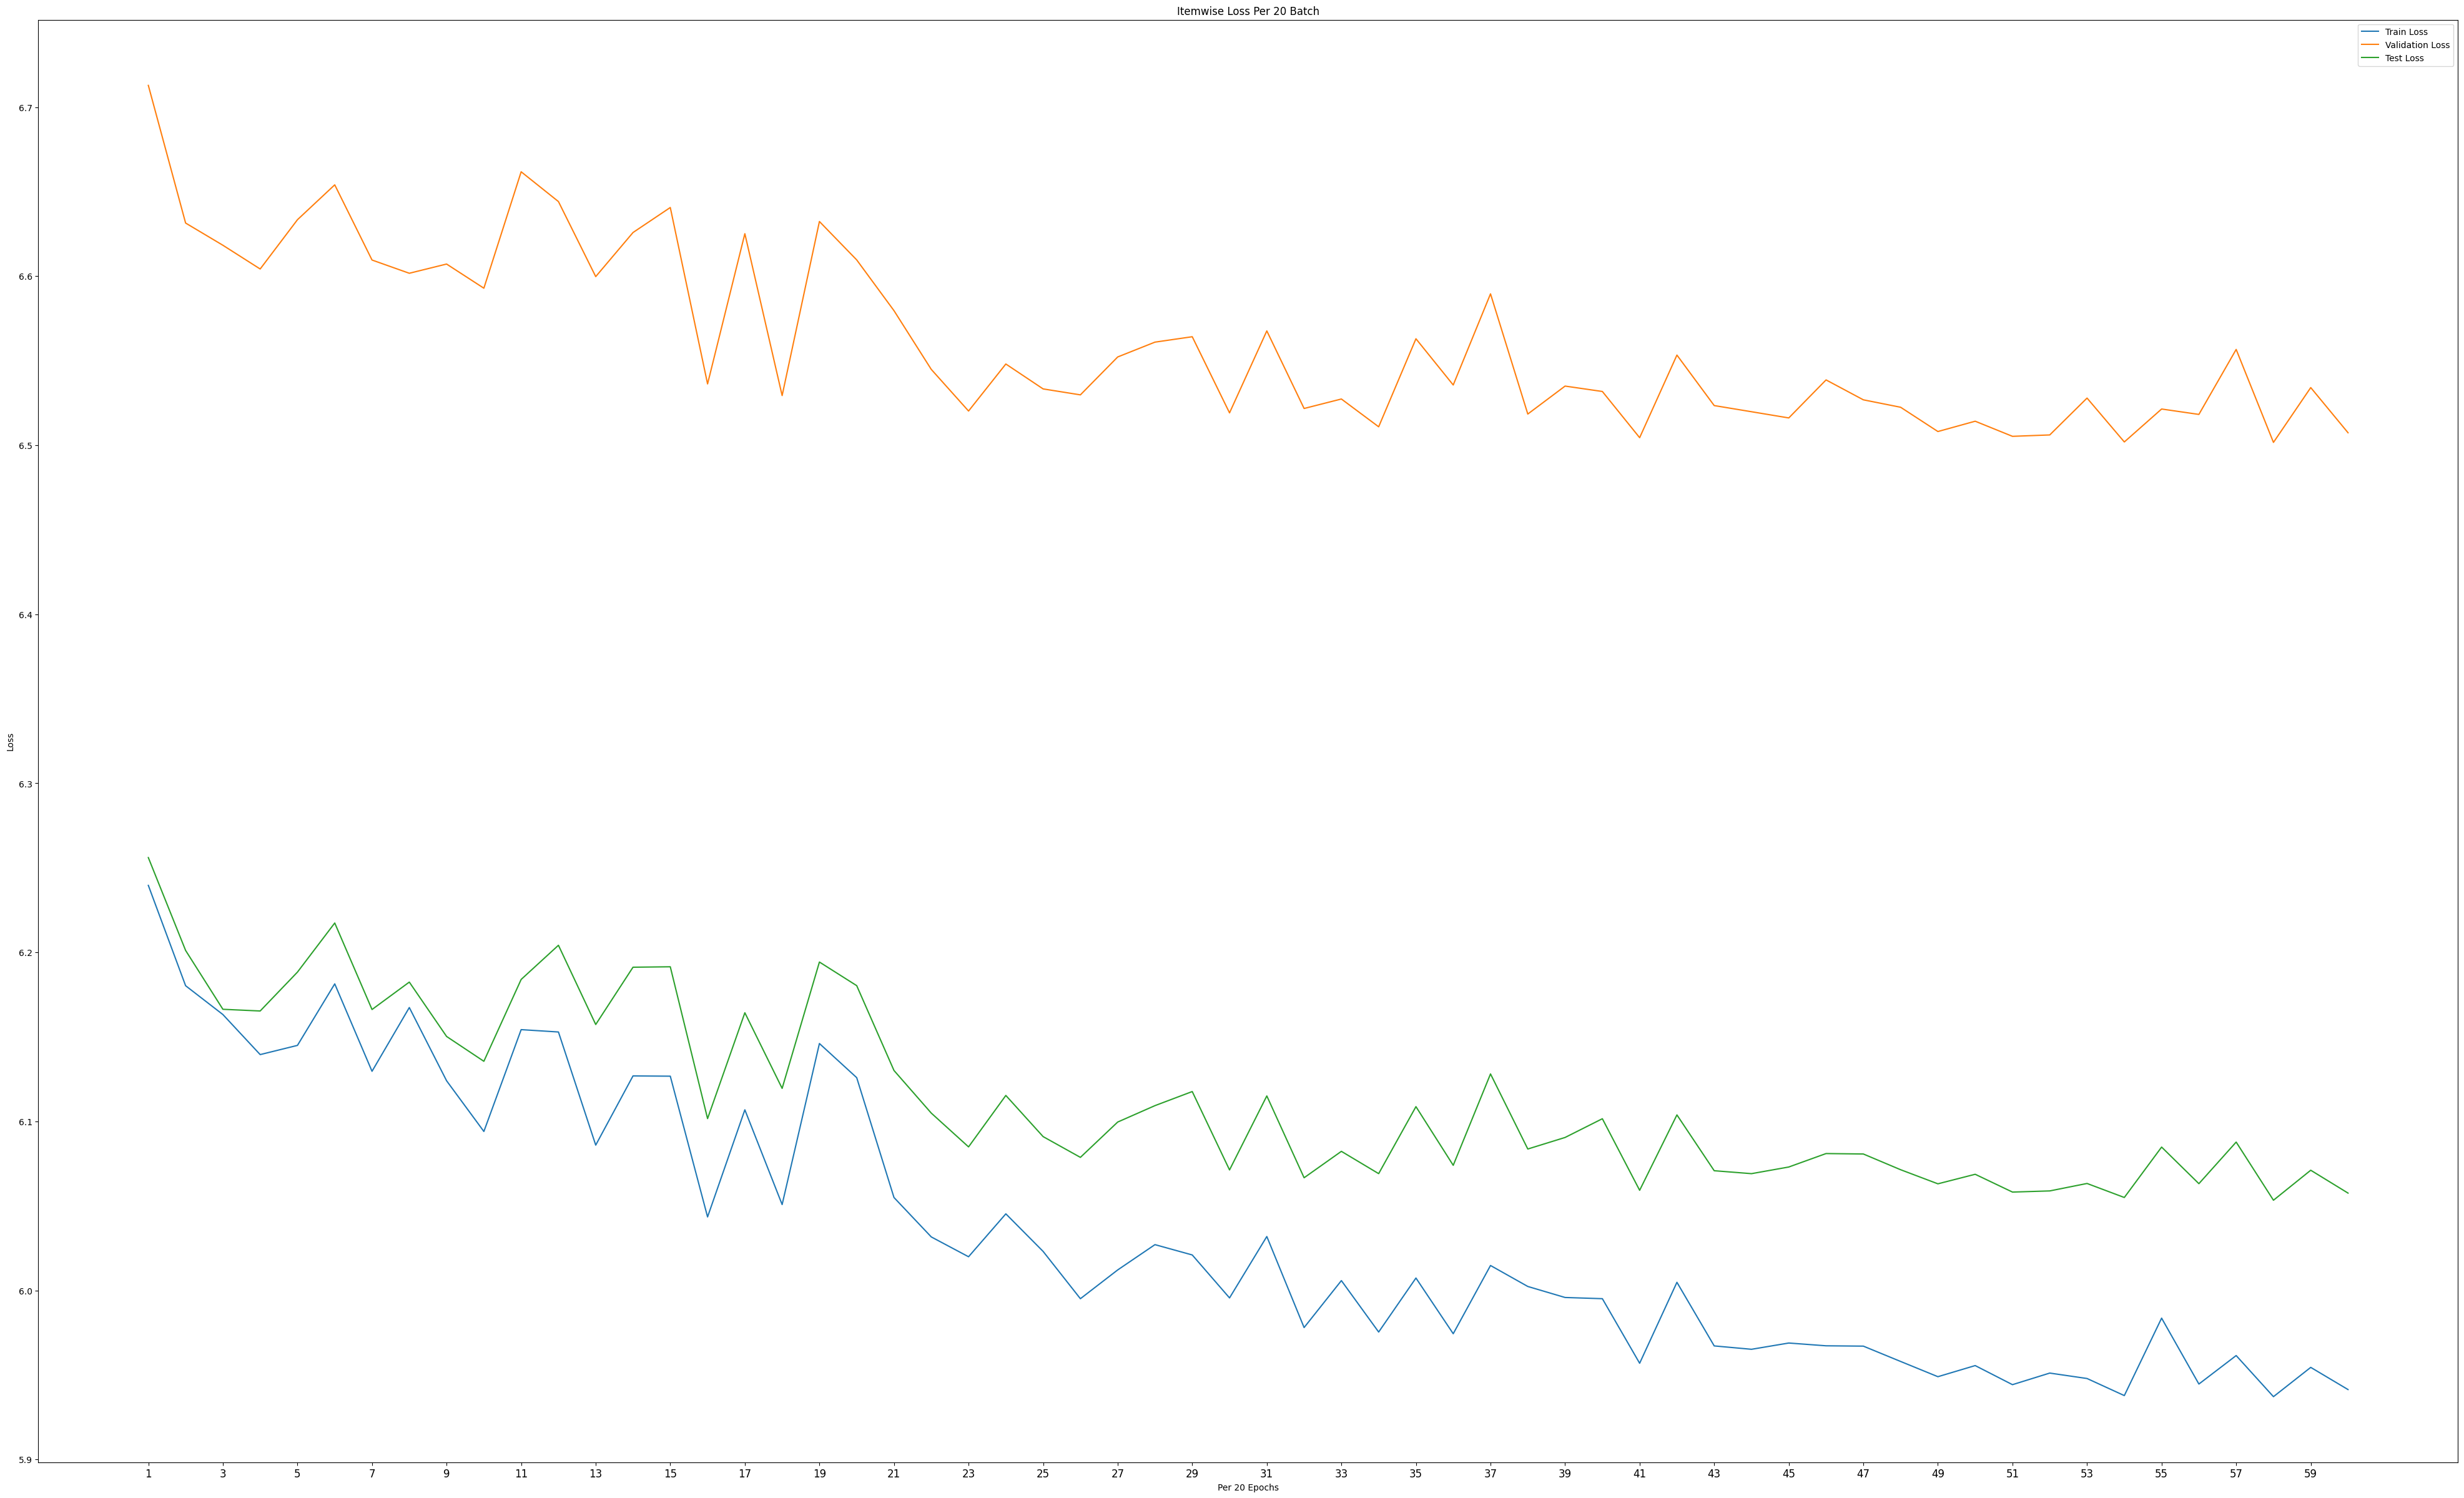

----------------------------------------------------------------------------------------------------
Performance of the BEST parameter setting on TEST set:
	 avg_COPULA_loss: 6.053367182612419
	 avg_MSE_loss_left_SE: 7.379972457885742
	 avg_MSE_loss_right_SE: 6.889222145080566
	 avg_MSE_loss_left_AL: 1.8453855514526367
	 avg_MSE_loss_right_AL: 1.7000768184661865
	 avg_MSE_loss_left: 9.225358009338379
	 avg_MSE_loss_right: 8.589299201965332
	 avg_MSE_loss_SE: 14.269194602966309
	 avg_MSE_loss_AL: 3.5454623699188232
	 avg_MSE_loss: 17.81465721130371
Fold 4
ei:  tensor([[ 2.4293, -2.0372,  0.5940,  ..., -0.9481, -0.8641,  2.0458],
        [ 0.6845, -0.2646,  0.8517,  ..., -0.7517, -0.3141, -0.2466],
        [ 3.8461, -2.9526, -0.3538,  ..., -1.4011, -2.7781,  1.5978],
        [ 1.7786, -0.6854,  0.3315,  ..., -1.1116, -1.1420, -0.3978]],
       device='cuda:0')


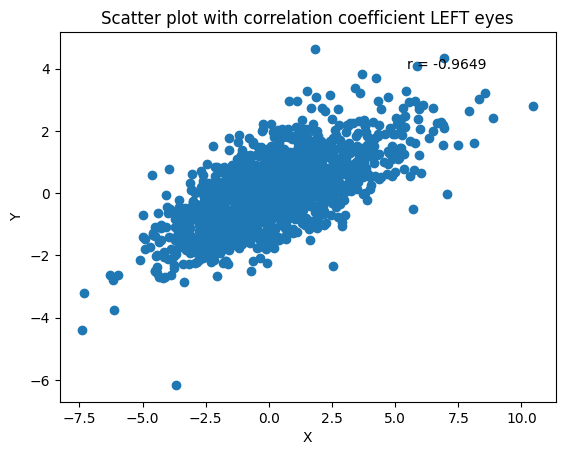

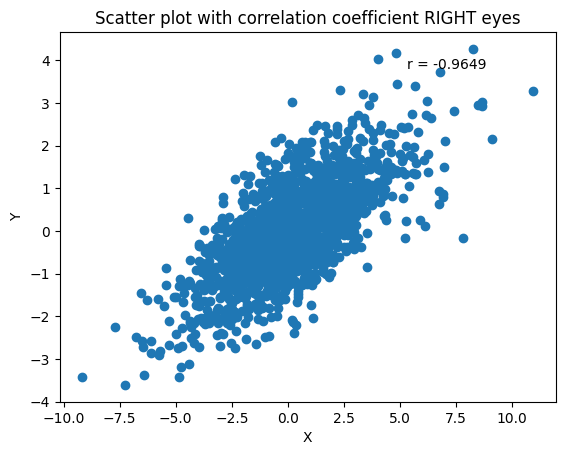

sigma_hat:  tensor([[5.1457, 1.6960, 3.8647, 1.2056],
        [1.6960, 1.2548, 1.1639, 0.9250],
        [3.8647, 1.1639, 5.5383, 1.8363],
        [1.2056, 0.9250, 1.8363, 1.2609]], device='cuda:0')
CopulaPara: 
gamma_hat:  tensor([[5.1457, 1.6960, 3.8647, 1.2056],
        [1.6960, 1.2548, 1.1639, 0.9250],
        [3.8647, 1.1639, 5.5383, 1.8363],
        [1.2056, 0.9250, 1.8363, 1.2609]], device='cuda:0')

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Learning rate is to 0.001 now.<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
----------------------------------------------------------------------------------------------------
Epoch 1/60
[Num of batch: 20] Avg train loss past 20 batch: 6.054 | Val LRClaRegTot loss this batch: 6.290 9.107 9.160 14.692 3.575 18.267 
[Num of batch: 40] Avg train loss past 20 batch: 6.147 | Val LRClaRegTot loss this batch: 6.272 9.983 9.233 15.573 3.642 19.215 
[Num of batch: 60] Avg train loss past 20 batch: 5.869 | Val LRClaRegTot loss this batch: 6.209 9.129 9.133 14.786 3.476 18.263 

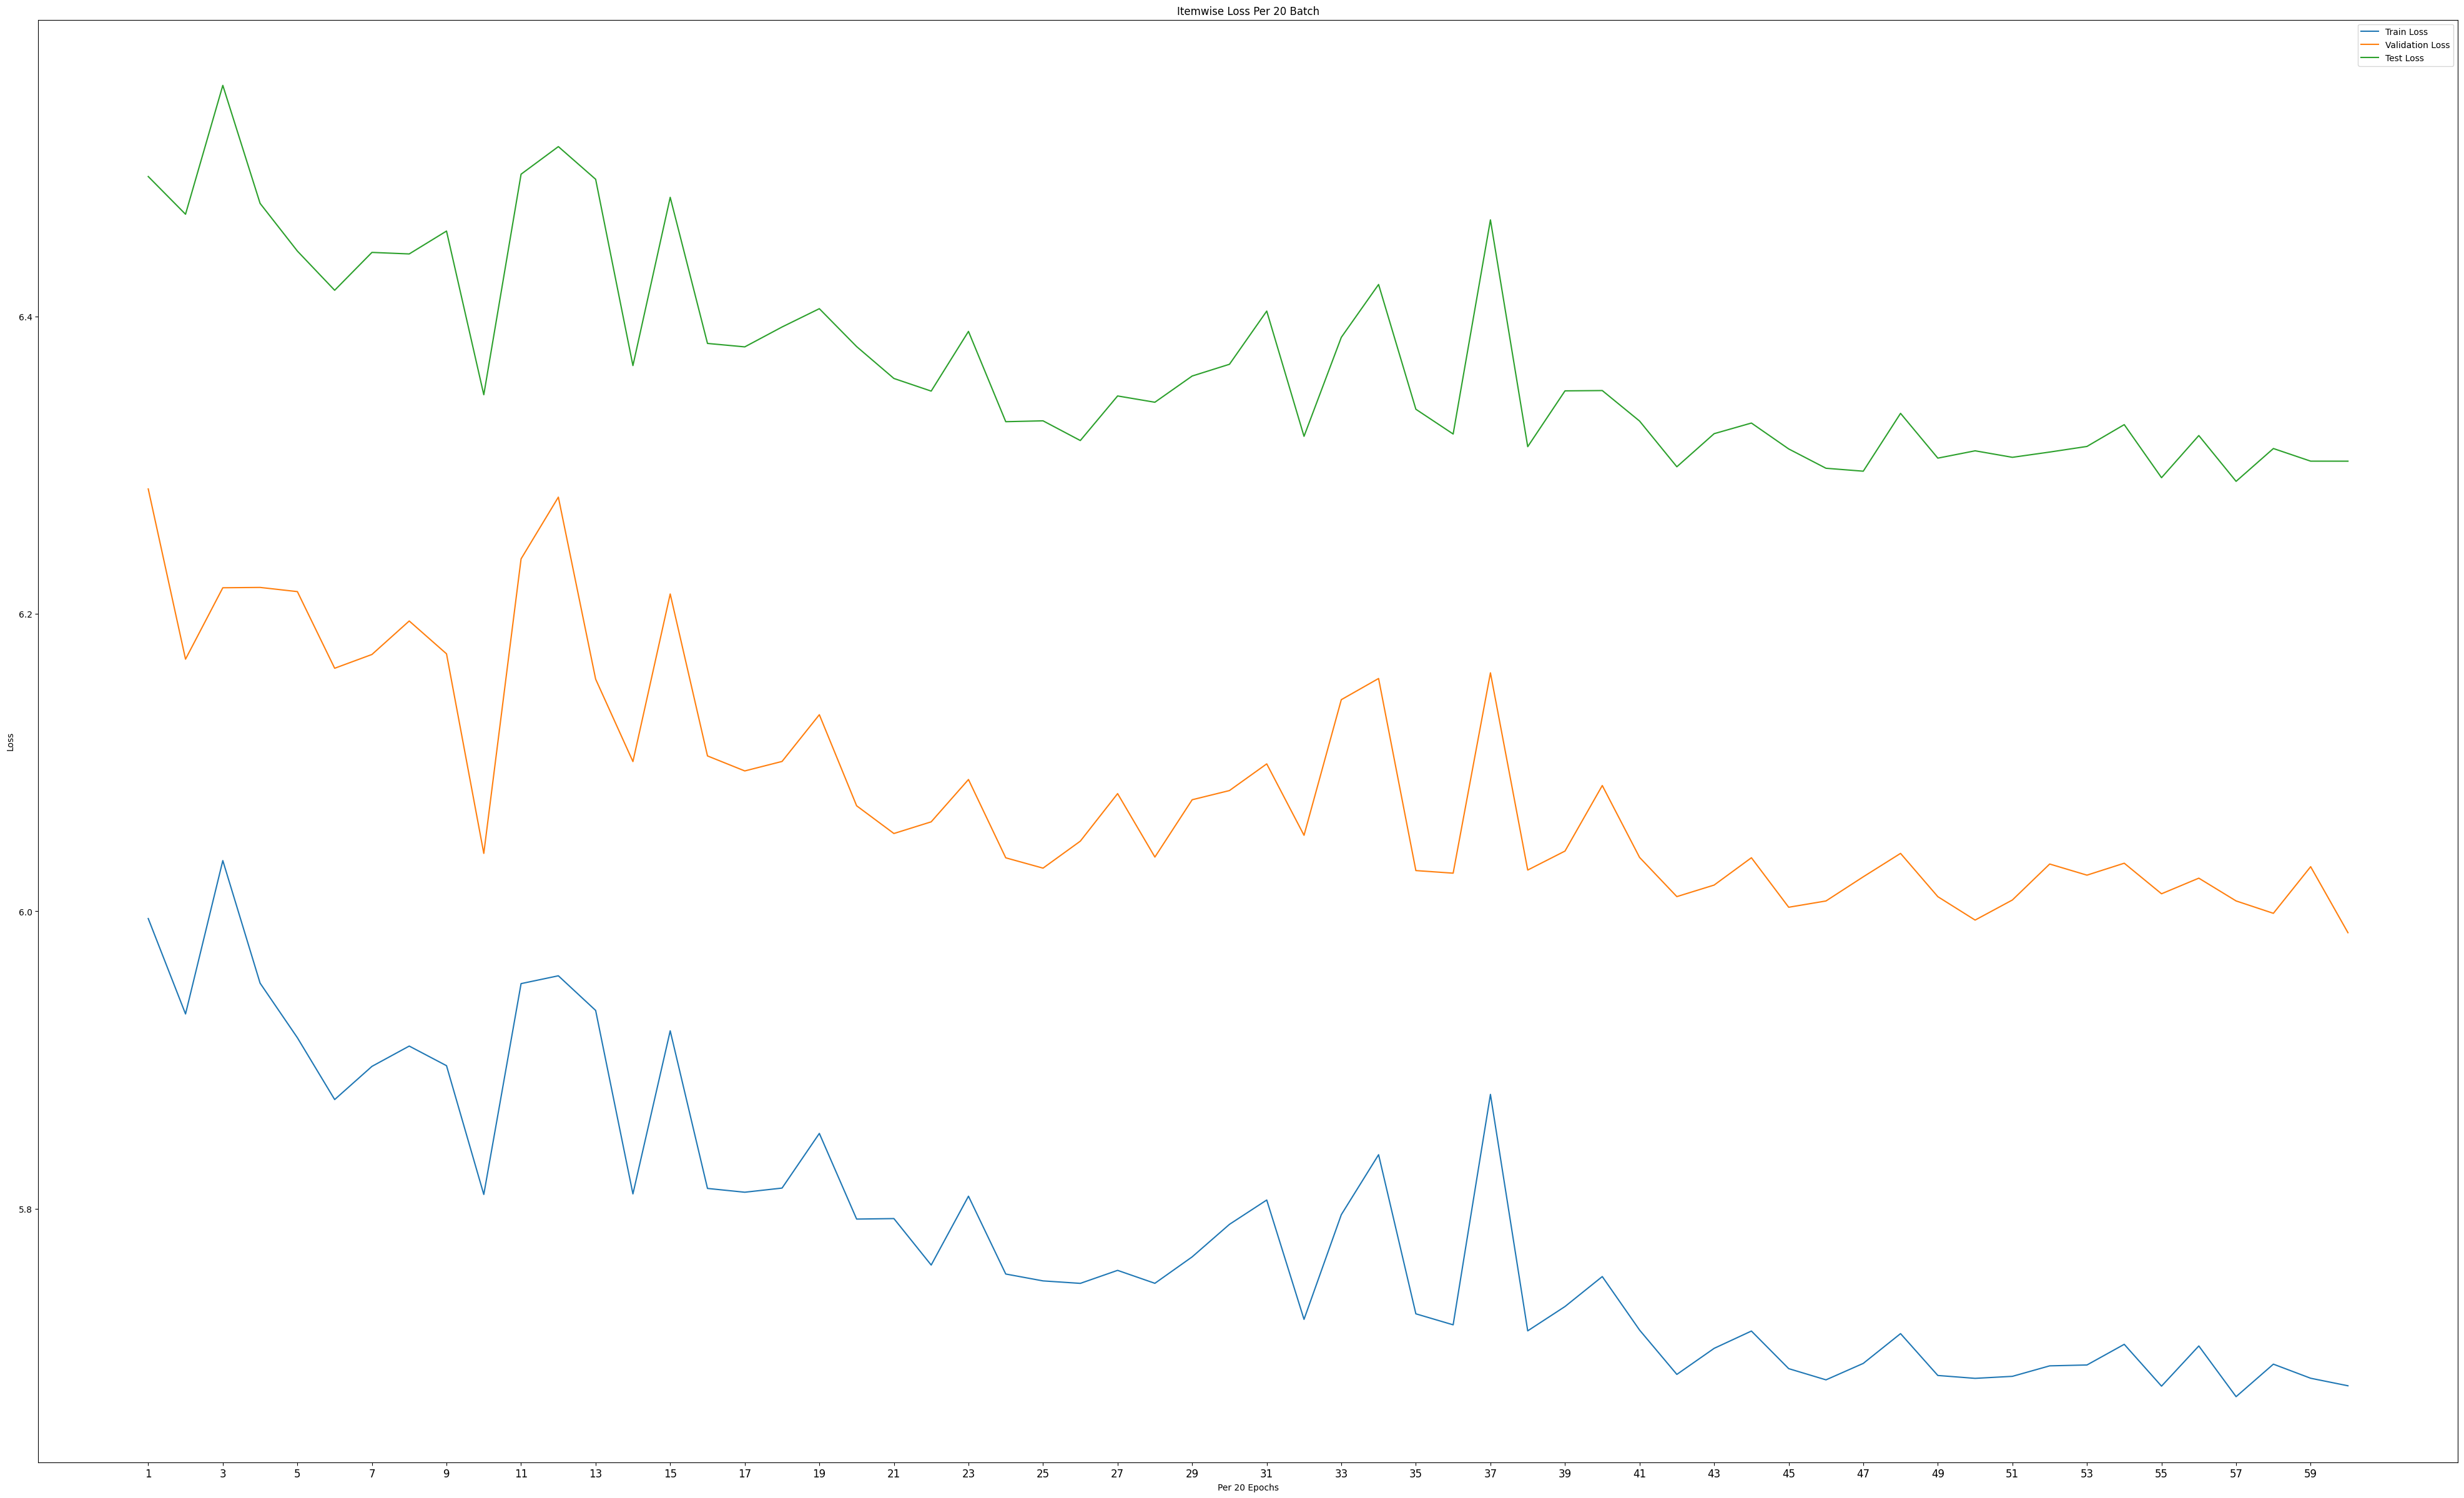

----------------------------------------------------------------------------------------------------
Performance of the BEST parameter setting on TEST set:
	 avg_COPULA_loss: 6.302654981613159
	 avg_MSE_loss_left_SE: 5.898533344268799
	 avg_MSE_loss_right_SE: 5.778416156768799
	 avg_MSE_loss_left_AL: 1.707883358001709
	 avg_MSE_loss_right_AL: 1.6917990446090698
	 avg_MSE_loss_left: 7.606416702270508
	 avg_MSE_loss_right: 7.470215320587158
	 avg_MSE_loss_SE: 11.676949501037598
	 avg_MSE_loss_AL: 3.3996825218200684
	 avg_MSE_loss: 15.076631546020508
Fold 5
ei:  tensor([[-0.3814, -1.9906,  4.3753,  ..., -1.5138,  2.6089, -5.7136],
        [ 0.2001, -0.9868,  3.7147,  ..., -1.5660,  0.5015, -2.4477],
        [ 0.8977,  0.0424,  2.8163,  ..., -0.0449,  0.6525, -3.9991],
        [ 0.4801,  0.0130,  2.4391,  ..., -0.7340, -0.8661, -1.2076]],
       device='cuda:0')


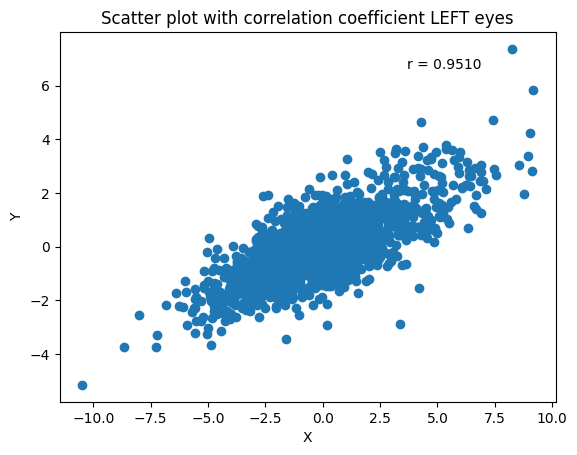

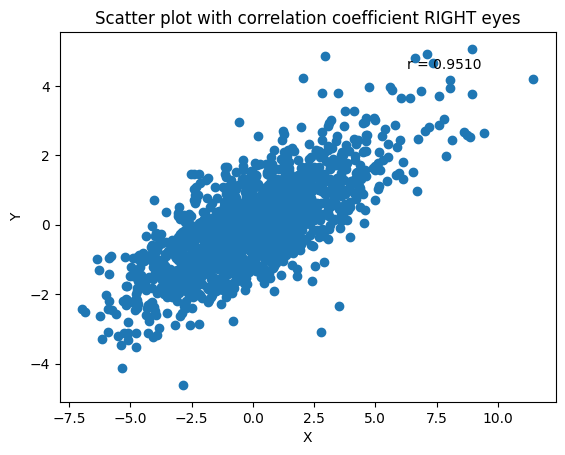

sigma_hat:  tensor([[6.5780, 2.3728, 4.6653, 1.6414],
        [2.3728, 1.5957, 1.6006, 1.1766],
        [4.6653, 1.6006, 6.4203, 2.3864],
        [1.6414, 1.1766, 2.3864, 1.6097]], device='cuda:0')
CopulaPara: 
gamma_hat:  tensor([[6.5780, 2.3728, 4.6653, 1.6414],
        [2.3728, 1.5957, 1.6006, 1.1766],
        [4.6653, 1.6006, 6.4203, 2.3864],
        [1.6414, 1.1766, 2.3864, 1.6097]], device='cuda:0')

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Learning rate is to 0.001 now.<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
----------------------------------------------------------------------------------------------------
Epoch 1/60
[Num of batch: 20] Avg train loss past 20 batch: 6.273 | Val LRClaRegTot loss this batch: 6.483 10.524 9.937 16.716 3.745 20.461 
[Num of batch: 40] Avg train loss past 20 batch: 6.241 | Val LRClaRegTot loss this batch: 6.389 10.352 10.409 16.770 3.992 20.762 
[Num of batch: 60] Avg train loss past 20 batch: 5.943 | Val LRClaRegTot loss this batch: 6.399 10.669 10.186 16.757 4.099 20

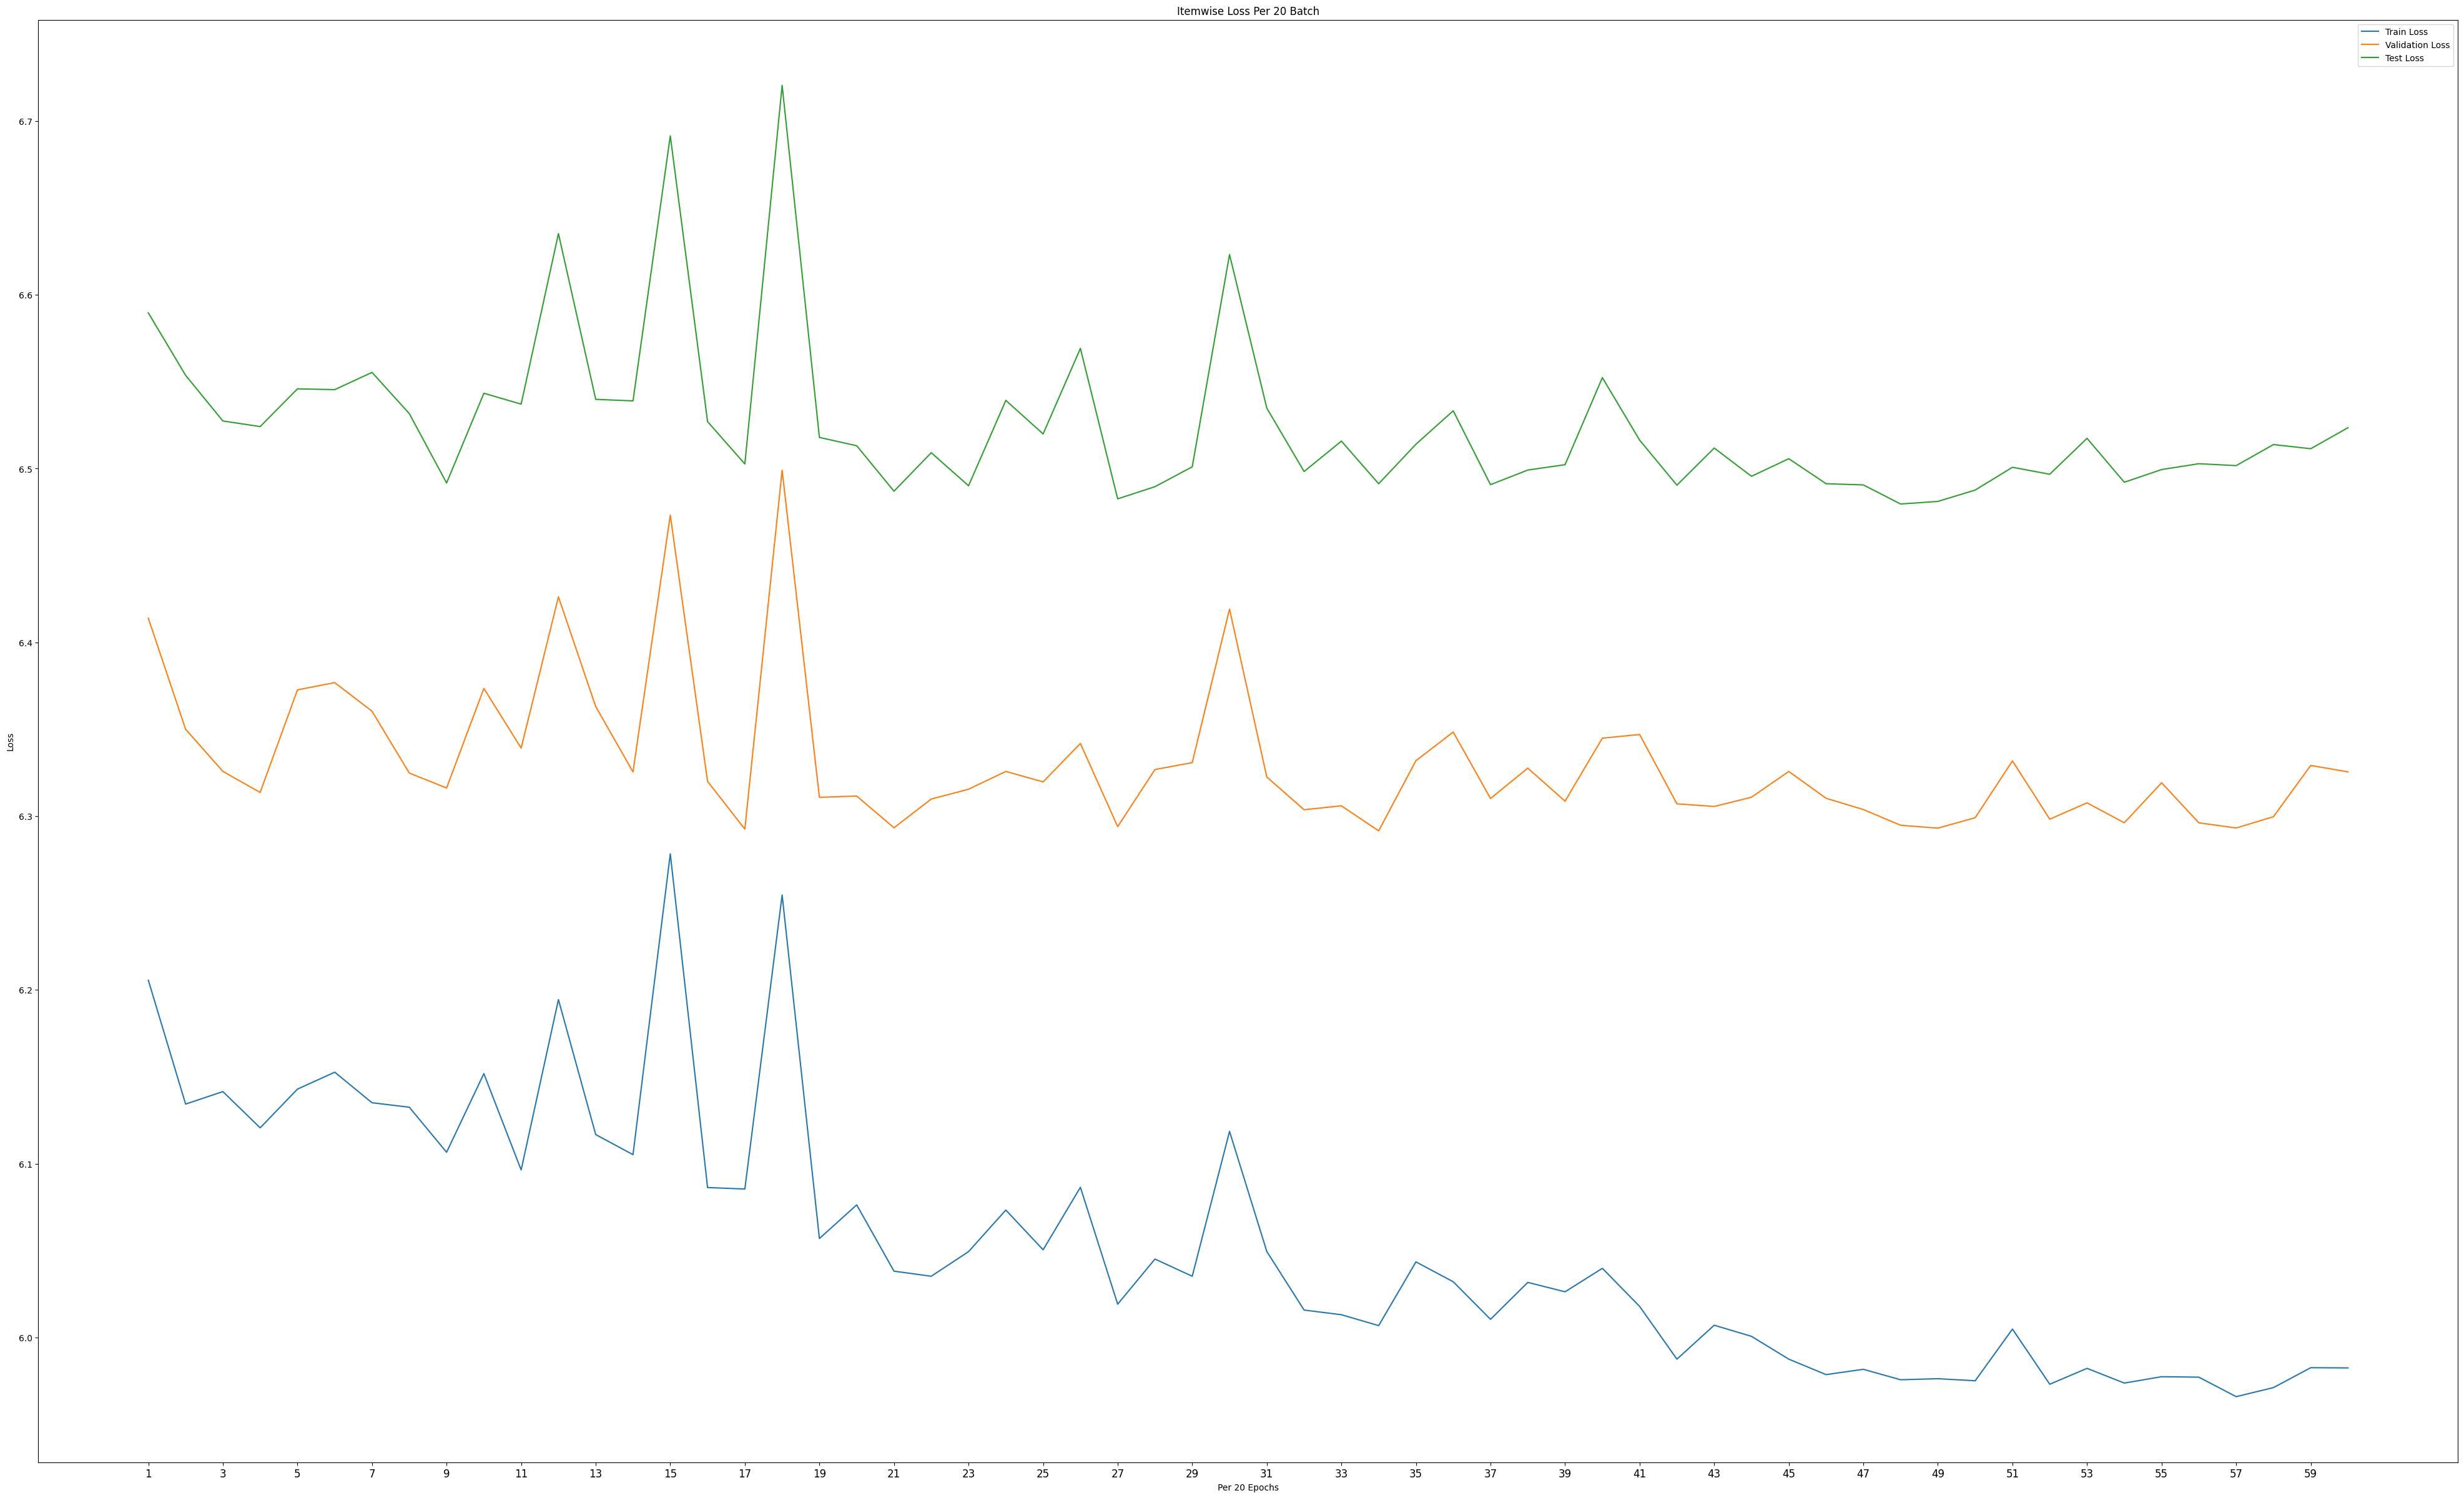

----------------------------------------------------------------------------------------------------
Performance of the BEST parameter setting on TEST set:
	 avg_COPULA_loss: 6.491267681121826
	 avg_MSE_loss_left_SE: 8.737638473510742
	 avg_MSE_loss_right_SE: 9.182750701904297
	 avg_MSE_loss_left_AL: 2.0648791790008545
	 avg_MSE_loss_right_AL: 2.061004638671875
	 avg_MSE_loss_left: 10.802517890930176
	 avg_MSE_loss_right: 11.243755340576172
	 avg_MSE_loss_SE: 17.92038917541504
	 avg_MSE_loss_AL: 4.125884056091309
	 avg_MSE_loss: 22.04627227783203
Training complete in 3531m 9s


In [15]:
for seed in seed_list:
    # K fold
    since = time.time() # 运行起始时间
    
#     set_seed(seed)  # <<<<<< SEED <<<<<<
    
#     ds_XL = data_generation()

    # oucopula = OUCopula(resnet_output_size=resnet_output_size)

    kfold = KFold(n_splits = k, shuffle = True, random_state = seed)

    history = {'avg_COPULA_loss': [],
               'avg_MSE_loss_left_SE': [],
               'avg_MSE_loss_right_SE': [],
               'avg_MSE_loss_left_AL': [],
               'avg_MSE_loss_right_AL': [],
               'avg_MSE_loss_left': [],
               'avg_MSE_loss_right': [],
               'avg_MSE_loss_SE': [],
               'avg_MSE_loss_AL': [],
               'avg_MSE_loss': []}

    # Print at the top banner
    print('=' * 48)
    batch_num_per_epoch = X_length * train_ratio * (1 - validation_split) // batch_size
    print("    ooo " + " " + "u   u" + " " + " ccc "+ " " + " ooo "+ " " + "pppp "+ " "  + "u   u" + " " + "l  "+ " " + "   a")
    print("  o   o" + " " + "u   u" + " " + "c    "+ " " + "o   o"+ " " + "p   p"+ " "  + "u   u"+ " " + "l   "+ " " + "  a a")
    print(" o   o" + " " + "u   u" + " " + "c    "+ " " + "o   o"+ " " + "pppp "+ " "  + "u   u"+ " " + "l   "+ " " + " aaaaa")
    print(" ooo " + " " + " uuu " + " " + " ccc "+ " " + " ooo "+ " " + "p    "+ " "  + " uuu "+ " " + "llll"+ " " + "a     a")
    print('=' * 48)
    print(f"WorkID: {work_id}")
    current_time = datetime.now()
    formatted_time = current_time.strftime("%Y-%m-%d %H:%M:%S")
    print("This experiment started at:", formatted_time)
    print('=' * 48)
    print("Important parameters: ")
    print("\tPython version:", sys.version)
    print("\tPytorch version: ", torch.__version__)
    print("\tBatch num per epoch: ", int(batch_num_per_epoch))
    print("\tlearning_rate: ", learning_rate)
    print("\tLearning rate decay every {} epoches.".format(lr_decay_step_size))
    print("Other parameters: ")
    print("\tRandom state KFold: ", seed)
    print("\tSeed: ", seed)
    print("\tKFold: ", k)
    print("\tBatch size: ", batch_size)
    print("\tNumber of epochs: ", num_epochs)
    print("\tSample size: ", X_length)
    # print("\tResNet输出的向量的维度: ", resnet_output_size)
    print("\tshuffle_train_set: ", shuffle_train_set)
    print("\ttrain_ratio (prop of train+val): ", train_ratio)
    print("\tvalidation_split: ", validation_split)
    print('=' * 48 + '\n')

    for fold, (train_idx, test_idx) in enumerate(kfold.split(np.arange(len(ds_XL)))):
        # For loss plot
        train_loss_batchwise_allfold = []
        val_loss_batchwise_allfold = []
        test_loss_batchwise_allfold = []

        print('=' * 60)
        print('Fold {}'.format(fold + 1))
        print('=' * 60)

        # For loss plot
        train_loss_batchwise_allfold = []
        val_loss_batchwise_allfold = []
        test_loss_batchwise_allfold = []

        # Load dl_train for this fold
        PATH_dl_train = f'/root/autodl-tmp/warmup loader files/WorkID{work_id}_Simu_Train_Data_seed{seed}_fold{fold}_X_length{X_length}_batchsize{batch_size}_num_epoch{120}.pt'
        train_loader = torch.load(PATH_dl_train)

        # Load dl_val for this fold
        PATH_dl_val = f'/root/autodl-tmp/warmup loader files/WorkID{work_id}_Simu_Val_Data_seed{seed}_fold{fold}_X_length{X_length}_batchsize{batch_size}_num_epoch{120}.pt'
        val_loader = torch.load(PATH_dl_val)

        # Load dl_test for this fold
        PATH_dl_test = f'/root/autodl-tmp/warmup loader files/WorkID{work_id}_Simu_Test_Data_seed{seed}_fold{fold}_X_length{X_length}_batchsize{batch_size}_num_epoch{120}.pt'
        test_loader = torch.load(PATH_dl_test)
        
        warm_up_PATH = f'/root/autodl-tmp/warmup loader files/WorkID{work_id}_Simu_Warmup_seed{seed}_fold{fold}_X_length{X_length}_batchsize{batch_size}_num_epoch{120}.pth'
        num_classes=[2,2]
        resnet_adapter = rsn10_adapter(num_classes).to(device)
        resnet_adapter.load_state_dict(torch.load(warm_up_PATH))
        
        sigma_hat = calculate_sigma_hat(train_loader,resnet_adapter)

        # 输出 Gamma and std_ei 供检查
        print("CopulaPara: ")
        print("gamma_hat: ", sigma_hat)
        print()


        # network参数
        

        # Criterion
        # criterion_classification = nn.BCEWithLogitsLoss()
        # criterion_classification = nn.BCELoss()
        criterion_regression = nn.MSELoss()
        criterion_copula = parametricLoss()

        # Observe that all parameters are being optimized
        optimizer = optim.Adam(resnet_adapter.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

        # Decay LR by a factor of ~ every ~ epochs
        exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=lr_decay_step_size, gamma=lr_decay_prop)

        #====== 训练模型 ======
        resnet_adapter, train_loss_batchwise, val_loss_batchwise, test_loss_batchwise = train_model(resnet_adapter, criterion_regression, criterion_copula, optimizer, exp_lr_scheduler, train_loader, val_loader, test_loader, num_epochs,sigma_hat)
            # Now oucopula is the best parameter setting acquired in this fold
        # Record batchwise for all folds to plot the loss plot for whole training process
        train_loss_batchwise_allfold = [*train_loss_batchwise_allfold, *train_loss_batchwise]
        val_loss_batchwise_allfold = [*val_loss_batchwise_allfold, *val_loss_batchwise]
        test_loss_batchwise_allfold = [*test_loss_batchwise_allfold, *test_loss_batchwise]

        # Plot train val test loss
        print('-' * 100)
        print("Train, validation, & test loss per 20 epoch")
        plot_loss(batch_num_per_epoch, train_loss_batchwise_allfold, val_loss_batchwise_allfold, test_loss_batchwise_allfold)

        #====== 记录模型 ======
        # For 本地
        copula_PATH = f'/root/autodl-tmp/warmup loader files/WorkID{work_id}_COPULA_seed{seed}_fold{fold}_X_length{X_length}_batchsize{batch_size}_num_epoch{num_epochs}.pth'

        # Save the best parameter setting in warm_up_PATH
        torch.save(resnet_adapter.state_dict(), copula_PATH) # 模型提取 state_dict状态字典 并保存

        #====== 测试模型 ======
        oucopula_test = rsn10_adapter(num_classes).to(device) # 载入模型之前先初始化
        oucopula_test.load_state_dict(torch.load(copula_PATH)) # 载入模型：先从PATH载入状态字典，再load_state_dict

        # Test the best model in this fold
        loss_summary = test_stage(oucopula_test, criterion_regression, criterion_copula, test_loader, sigma_hat)

        # history['Classification_accuracy'].append(Classification_accuracy)
        # history['Regression_loss'].append(Regression_loss)

        # Record the number into the dict
        for key, val in loss_summary.items():
            if torch.is_tensor(val):
                val = val.item()
            history[key].append(val)

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    # 输出到csv上的结果，我们只基于test dataset
    pd.DataFrame(history).to_csv(f'./Simu/WorkID{work_id}_COPULA_seed{seed}_X_length{X_length}_batchsize{batch_size}_num_epoch{num_epochs}.csv', index=True)
